# Cross-matching entre 2 tables 

Il faut remplacer le nom des variables par les tables qu'on souhaite comparer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import math
import scipy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import Planck13
import pickle
import os
import random
from collections import Counter
from scipy.spatial import cKDTree

In [2]:
from gem_astmatch_modified import match_celestial_objects_list_deg,match_celestial_objects,create_skycoord_from_fits,do_celest_match_fits   

# Import catalogues

Fonction pour passer de .fit à un dataframe (REMARQUE : Le programme ne semble pas fonctionner pour certains fits binary → dans le doute télécharger des fits ascii) : 

In [3]:
# Transforme certaines extensions d'un fichier FITS en un fichier FITS ASCII
def fits_binary_to_fits_ascii_list(fits_file, liste_indexes, name_list):  # liste_indexes indique les extensions du fits à lire ; name_list correspond aux noms des fichiers de sortie
    for x, x_name in zip(liste_indexes, name_list):  # Use zip to iterate over both lists simultaneously
        with fits.open(fits_file) as hdul:
            data = hdul[x].data
            data_table = Table(data)  # Convertit le tableau binaire en un tableau astropy
            data_table.write(x_name, overwrite=True, format='ascii')  # Écrit le tableau dans un fichier FITS ASCII

#Transforme un FITS ascii en un DataFrame pandas
def ascii_to_dataframe(ascii_file, delimiter=' '):
    data_df = pd.read_csv(ascii_file, delimiter=delimiter)
    return data_df

# Transfome la première extension d'un fichier FITS en un DataFrame pandas
def fits_to_dataframe(fits_file):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data 
        data_df = pd.DataFrame(data)
    return data_df




# Transforme certaines extensions d'un fichier FITS en un DataFrame pandas(→ pour que ça fonctionne, il faut un fits ascii et pas un fits binaire)
def fits_to_dataframe_list(fits_file, liste_indexes):  # liste_indexes indique les extensions du fits à lire
    df_list = []  # Initialize the list outside the loop
    with fits.open(fits_file) as hdul:
        for x in liste_indexes:
            data = hdul[x].data  # Select the data in the xth extension
            df_list.append(pd.DataFrame(data))
            print(df_list)
    return df_list  # Return the entire list of DataFrames

#def fits_binary_to_fits_ascii(fits_file):

On précise le chemin menant à chacun des catalogues pour ensuite les importer

In [4]:
path_1 = '../SCUSS_DESI/SCUSS_Gao_2020.fit' #la première table est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen
name_1 = 'SCUSS_Gao_2020'

path_2 = '../SCUSS_DESI/DESI_Legacy_Wen_2024.fit'
name_2 = 'Wen_2024_DESI_Legacy'


table_1 = fits_to_dataframe(path_1)

table_2 = fits_to_dataframe(path_2)

In [5]:
table_2

_RAJ2000  _DEJ2000       ID n_Name              Name    RAJ2000  \
0          0.00046 -37.47628        1         J000000.1-372835    0.00046   
1          0.00135 -56.58835        2    WH-  J000000.3-563518    0.00135   
2          0.00172 -39.32369        3         J000000.4-391925    0.00172   
3          0.00201   2.31980        4         J000000.5+021911    0.00201   
4          0.00260 -59.01297        5    WH-  J000000.6-590047    0.00260   
...            ...       ...      ...    ...               ...        ...   
1581174  359.99667   4.99211  1581175    WH-  J235959.2+045932  359.99667   
1581175  359.99680  21.78514  1581176         J235959.2+214707  359.99680   
1581176  359.99817  10.04951  1581177         J235959.6+100258  359.99817   
1581177  359.99847  -6.34469  1581178    WH-  J235959.6-062041  359.99847   
1581178  359.99902   7.67085  1581179         J235959.8+074015  359.99902   

          DEJ2000     zCl  f_zCl    zmag  ...  logMs   r500  lam500  M500  \
0       -37.47628  0.1364      0  15.377  ...  11.49  0.766   25.79  1.17   
1       -56.58835  0.1957      0  15.712  ...  11.70  0.625   23.24  1.06   
2       -39.32369  0.3580      0  17.713  ...  11.41  0.526   15.90  0.73   
3         2.31980  0.4282      1  18.043  ...  11.55  0.612   23.40  1.07   
4       -59.01297  0.1380      0  14.993  ...  11.69  0.606   15.71  0.73   
...           ...     ...    ...     ...  ...    ...    ...     ...   ...   
1581174   4.99211  0.5948      0  19.184  ...  11.37  0.420   10.99  0.51   
1581175  21.78514  0.4050      1  17.259  ...  11.78  0.658   31.73  1.43   
1581176  10.04951  0.7919      0  18.904  ...  11.88  0.621   33.23  1.50   
1581177  -6.34469  1.0333      0  20.952  ...  11.18  0.439   13.12  0.61   
1581178   7.67085  0.6633      0  19.532  ...  11.27  0.542   14.02  0.65   

         Ngal  Gamma  e_Gamma  imag_        Cat    recno  
0          14    0.0      0.0      1  WHY18            1  
1           7    0.0      0.0      1                   2  
2           7    0.0      0.0      1  Y21              3  
3          13    0.0      0.0      1  redMaPPer        4  
4           7    0.0      0.0      1                   5  
...       ...    ...      ...    ...        ...      ...  
1581174     6    0.0      0.0      2             1581175  
1581175     9    0.0      0.0      2  WHL        1581176  
1581176     8    0.0      0.0      2  CFSFDP     1581177  
1581177     6    0.0      0.0      2             1581178  
1581178     9    0.0      0.0      2  Y21        1581179  

[1581179 rows x 21 columns]

In [6]:
table_1

_RAJ2000  _DEJ2000   Name    RAJ2000   DEJ2000     zph      zsp  \
0        0.00035  13.02347      0    0.00035  13.02347  0.3769  0.00000   
1        0.00635   2.95542      1    0.00635   2.95542  0.4571  0.42290   
2        0.00958   5.28826      2    0.00958   5.28826  0.1734  0.16936   
3        0.01474  31.78564      3    0.01474  31.78564  0.0824  0.00000   
4        0.01476   8.94881      4    0.01476   8.94881  0.2609  0.00000   
...          ...       ...    ...        ...       ...     ...      ...   
19605  359.97270  13.33689  19605  359.97270  13.33689  0.2360  0.24498   
19606  359.98382   3.48642  19606  359.98382   3.48642  0.5132  0.00000   
19607  359.98503  -3.43589  19607  359.98503  -3.43589  0.3251  0.00000   
19608  359.98757   8.56171  19608  359.98757   8.56171  0.3556  0.00000   
19609  359.99500   0.70176  19609  359.99500   0.70176  0.0844  0.08167   

       zphmedian  N1Mpc     L1Mpc  Richness  M500  recno  
0        0.38710     24   7.00224  22.90440  1.26      1  
1        0.43890     17   6.56276  23.13604  1.27      2  
2        0.17750     58  14.09044  35.83500  2.04      3  
3        0.10490     64  12.95997  25.62747  1.42      4  
4        0.27620     26   8.83946  24.11363  1.33      5  
...          ...    ...       ...       ...   ...    ...  
19605    0.23050     24   6.31375  14.90396  0.79  19606  
19606    0.51320     20   8.83291  40.95954  2.35  19607  
19607    0.32065     26   8.59997  26.87073  1.49  19608  
19608    0.37079     14   3.79424   9.74870  0.50  19609  
19609    0.08237     67  11.35429  21.47977  1.17  19610  

[19610 rows x 13 columns]

In [7]:
# On calcule les coordonnées galactiques

'''# objets table 1 
raj2000_1_list = table_1['RAJ2000'].tolist()
dej2000_1_list = table_1['DEJ2000'].tolist()
j2000_coords_1 = SkyCoord(raj2000_1_list, dej2000_1_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_1 = j2000_coords_1.galactic # conversion J2000 -> galactique

# objets table 2
raj2000_2_list = table_2['RAJ2000'].tolist()
dej2000_2_list = table_2['DEJ2000'].tolist()
j2000_coords_2 = SkyCoord(raj2000_2_list, dej2000_2_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_2 = j2000_coords_2.galactic # conversion J2000 -> galactique'''


output_folder = "../SCUSS_DESI/"  


'''# Save 'galactic_coords_x'
with open(os.path.join(output_folder, f'galactic_coords_{name_1}.pkl'), 'wb') as file:
    pickle.dump(galactic_coords_1, file)

# Save 'galactic_coords_2'
with open(os.path.join(output_folder, f'galactic_coords_{name_2}.pkl'), 'wb') as file:
    pickle.dump(galactic_coords_2, file)'''

"# Save 'galactic_coords_x'\nwith open(os.path.join(output_folder, f'galactic_coords_{name_1}.pkl'), 'wb') as file:\n    pickle.dump(galactic_coords_1, file)\n\n# Save 'galactic_coords_2'\nwith open(os.path.join(output_folder, f'galactic_coords_{name_2}.pkl'), 'wb') as file:\n    pickle.dump(galactic_coords_2, file)"

In [8]:
# On récupère les coordonnées galactiques et on les ajoute aux tables

with open(os.path.join(output_folder, f'galactic_coords_{name_1}.pkl'), 'rb') as file:
    galactic_coords_1 = pickle.load(file)
with open(os.path.join(output_folder, f'galactic_coords_{name_2}.pkl'), 'rb') as file:
    galactic_coords_2 = pickle.load(file)

table_1['glon'] = galactic_coords_1.l.deg ; table_1['glat'] = galactic_coords_1.b.deg
table_1 = table_1[['glat'] + [col for col in table_1.columns if col != 'glat']]
table_1 = table_1[['glon'] + [col for col in table_1.columns if col != 'glon']]

table_2['glon'] = galactic_coords_2.l.deg ; table_2['glat'] = galactic_coords_2.b.deg
table_2 = table_2[['glat'] + [col for col in table_2.columns if col != 'glat']]
table_2 = table_2[['glon'] + [col for col in table_2.columns if col != 'glon']]



In [9]:
table_1

glon       glat   _RAJ2000  _DEJ2000   Name    RAJ2000   DEJ2000  \
0      104.041987 -47.952774    0.00035  13.02347      0    0.00035  13.02347   
1       98.536862 -57.460835    0.00635   2.95542      1    0.00635   2.95542   
2      100.049582 -55.283444    0.00958   5.28826      2    0.00958   5.28826   
3      110.350582 -29.827790    0.01474  31.78564      3    0.01474  31.78564   
4      102.115166 -51.834197    0.01476   8.94881      4    0.01476   8.94881   
...           ...        ...        ...       ...    ...        ...       ...   
19605  104.141421 -47.645372  359.97270  13.33689  19605  359.97270  13.33689   
19606   98.856970 -56.958426  359.98382   3.48642  19606  359.98382   3.48642   
19607   93.260257 -63.301439  359.98503  -3.43589  19607  359.98503  -3.43589   
19608  101.871431 -52.192059  359.98757   8.56171  19608  359.98757   8.56171   
19609   96.879807 -59.541778  359.99500   0.70176  19609  359.99500   0.70176   

          zph      zsp  zphmedian  N1Mpc     L1Mpc  Richness  M500  recno  
0      0.3769  0.00000    0.38710     24   7.00224  22.90440  1.26      1  
1      0.4571  0.42290    0.43890     17   6.56276  23.13604  1.27      2  
2      0.1734  0.16936    0.17750     58  14.09044  35.83500  2.04      3  
3      0.0824  0.00000    0.10490     64  12.95997  25.62747  1.42      4  
4      0.2609  0.00000    0.27620     26   8.83946  24.11363  1.33      5  
...       ...      ...        ...    ...       ...       ...   ...    ...  
19605  0.2360  0.24498    0.23050     24   6.31375  14.90396  0.79  19606  
19606  0.5132  0.00000    0.51320     20   8.83291  40.95954  2.35  19607  
19607  0.3251  0.00000    0.32065     26   8.59997  26.87073  1.49  19608  
19608  0.3556  0.00000    0.37079     14   3.79424   9.74870  0.50  19609  
19609  0.0844  0.08167    0.08237     67  11.35429  21.47977  1.17  19610  

[19610 rows x 15 columns]

In [10]:
table_2

glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
0        346.037516 -75.021144    0.00046 -37.47628        1          
1        316.752759 -59.138458    0.00135 -56.58835        2    WH-   
2        340.962781 -73.774528    0.00172 -39.32369        3          
3         98.087140 -58.049446    0.00201   2.31980        4          
4        315.038146 -56.890161    0.00260 -59.01297        5    WH-   
...             ...        ...        ...       ...      ...    ...   
1581174   99.846285 -55.556496  359.99667   4.99211  1581175    WH-   
1581175  107.386200 -39.528434  359.99680  21.78514  1581176          
1581176  102.648089 -50.784985  359.99817  10.04951  1581177          
1581177   90.146970 -65.886375  359.99847  -6.34469  1581178    WH-   
1581178  101.410122 -53.037823  359.99902   7.67085  1581179          

                     Name    RAJ2000   DEJ2000     zCl  ...  logMs   r500  \
0        J000000.1-372835    0.00046 -37.47628  0.1364  ...  11.49  0.766   
1        J000000.3-563518    0.00135 -56.58835  0.1957  ...  11.70  0.625   
2        J000000.4-391925    0.00172 -39.32369  0.3580  ...  11.41  0.526   
3        J000000.5+021911    0.00201   2.31980  0.4282  ...  11.55  0.612   
4        J000000.6-590047    0.00260 -59.01297  0.1380  ...  11.69  0.606   
...                   ...        ...       ...     ...  ...    ...    ...   
1581174  J235959.2+045932  359.99667   4.99211  0.5948  ...  11.37  0.420   
1581175  J235959.2+214707  359.99680  21.78514  0.4050  ...  11.78  0.658   
1581176  J235959.6+100258  359.99817  10.04951  0.7919  ...  11.88  0.621   
1581177  J235959.6-062041  359.99847  -6.34469  1.0333  ...  11.18  0.439   
1581178  J235959.8+074015  359.99902   7.67085  0.6633  ...  11.27  0.542   

         lam500  M500  Ngal  Gamma  e_Gamma  imag_        Cat    recno  
0         25.79  1.17    14    0.0      0.0      1  WHY18            1  
1         23.24  1.06     7    0.0      0.0      1                   2  
2         15.90  0.73     7    0.0      0.0      1  Y21              3  
3         23.40  1.07    13    0.0      0.0      1  redMaPPer        4  
4         15.71  0.73     7    0.0      0.0      1                   5  
...         ...   ...   ...    ...      ...    ...        ...      ...  
1581174   10.99  0.51     6    0.0      0.0      2             1581175  
1581175   31.73  1.43     9    0.0      0.0      2  WHL        1581176  
1581176   33.23  1.50     8    0.0      0.0      2  CFSFDP     1581177  
1581177   13.12  0.61     6    0.0      0.0      2             1581178  
1581178   14.02  0.65     9    0.0      0.0      2  Y21        1581179  

[1581179 rows x 23 columns]

# Visualisation zones communes et sélection

On va notamment chercher à quantifier l'efficacité de l'association, c'est à dire le rapport d'amas 1 associés sur le rapport d'amas 1 total : cependant pour que cela ait un intérêt, il nous faut auparavant sélectionner les objets situés dans les footprint communes aux objets 1 et 2.

## Visualisation (en coordonnées galactiques)

In [11]:
#Transformation des coordonnées galactiques en listes

glon_1 = table_1['glon'].tolist() ; glat_1 = table_1['glat'].tolist()

glon_2 = table_2['glon'].tolist() ; glat_2 = table_2['glat'].tolist()


In [12]:
# On ajoute une variable binaire "NEED_TO_VIZUALISE" pour n'afficher les graphes que quand c'est utile (c'est à dire quand on cherche à définir les zones de footprints communes)
NEED_TO_VIZUALISE = True

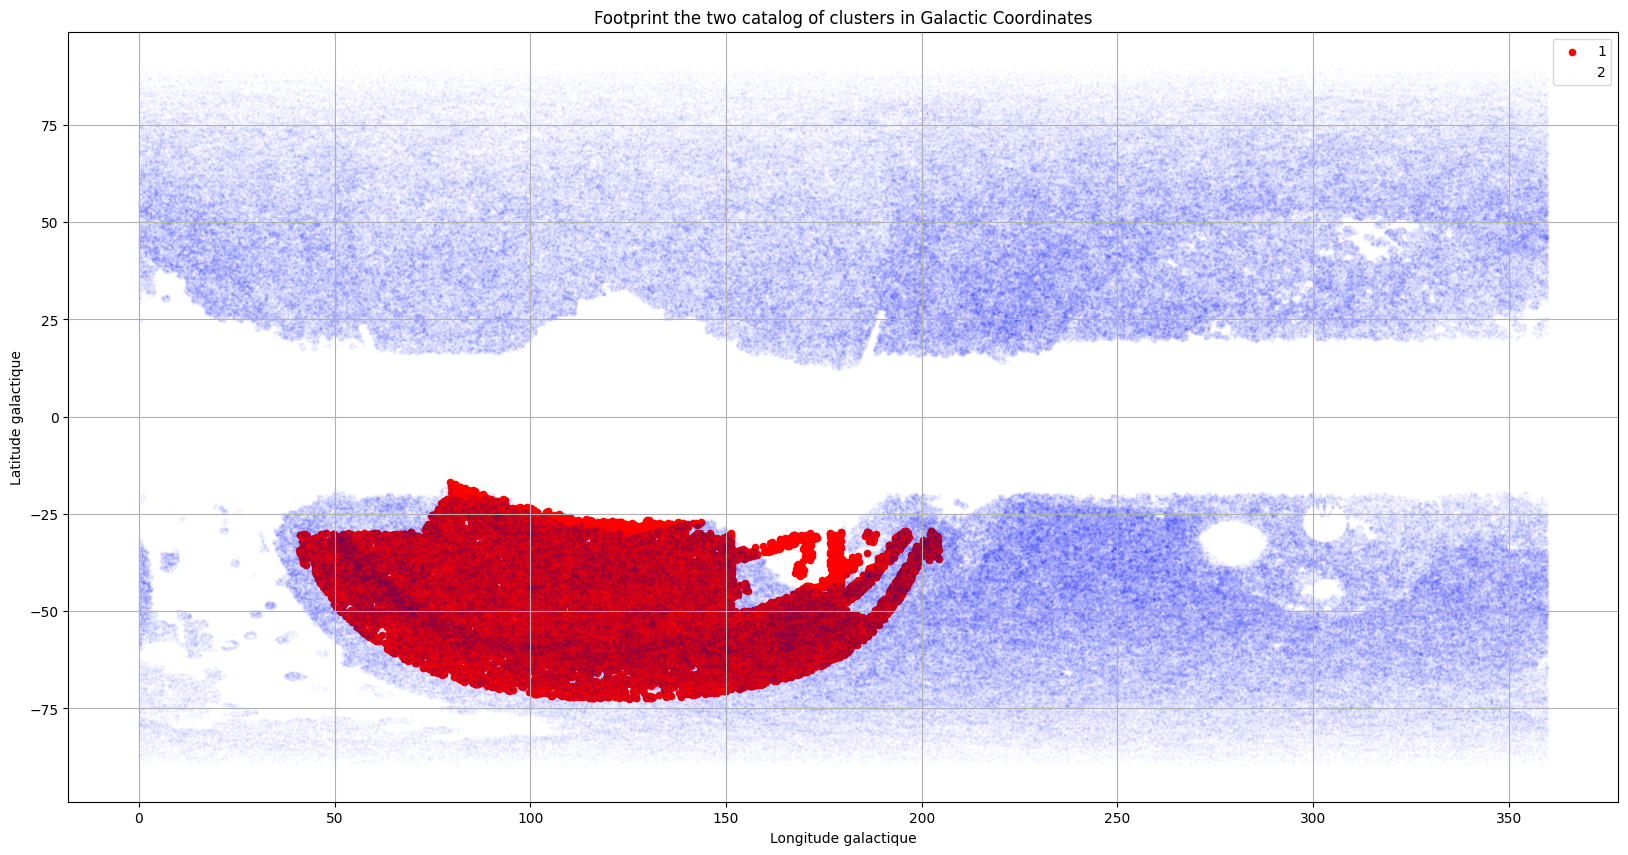

In [27]:
if NEED_TO_VIZUALISE:

    fig = plt.figure(figsize=(20, 10))
    ax_projection_1_all = plt.subplot(111)
    ax_projection_2_all = plt.subplot(111)

    ax_projection_1_all.scatter(glon_1, glat_1, s=20,facecolors='red',label='1') 
    ax_projection_1_all.grid(True)
    ax_projection_1_all.set_xlabel("Longitude galactique")
    ax_projection_1_all.set_ylabel("Latitude galactique")

    ax_projection_2_all.scatter(glon_2, glat_2,s=1,edgecolors='blue',alpha=0.01,label='2') 
    ax_projection_2_all.grid(True)
    ax_projection_2_all.set_xlabel("Longitude galactique")
    ax_projection_2_all.set_ylabel("Latitude galactique")

   


    plt.title(f"Footprint the two catalog of clusters in Galactic Coordinates")
    plt.legend()

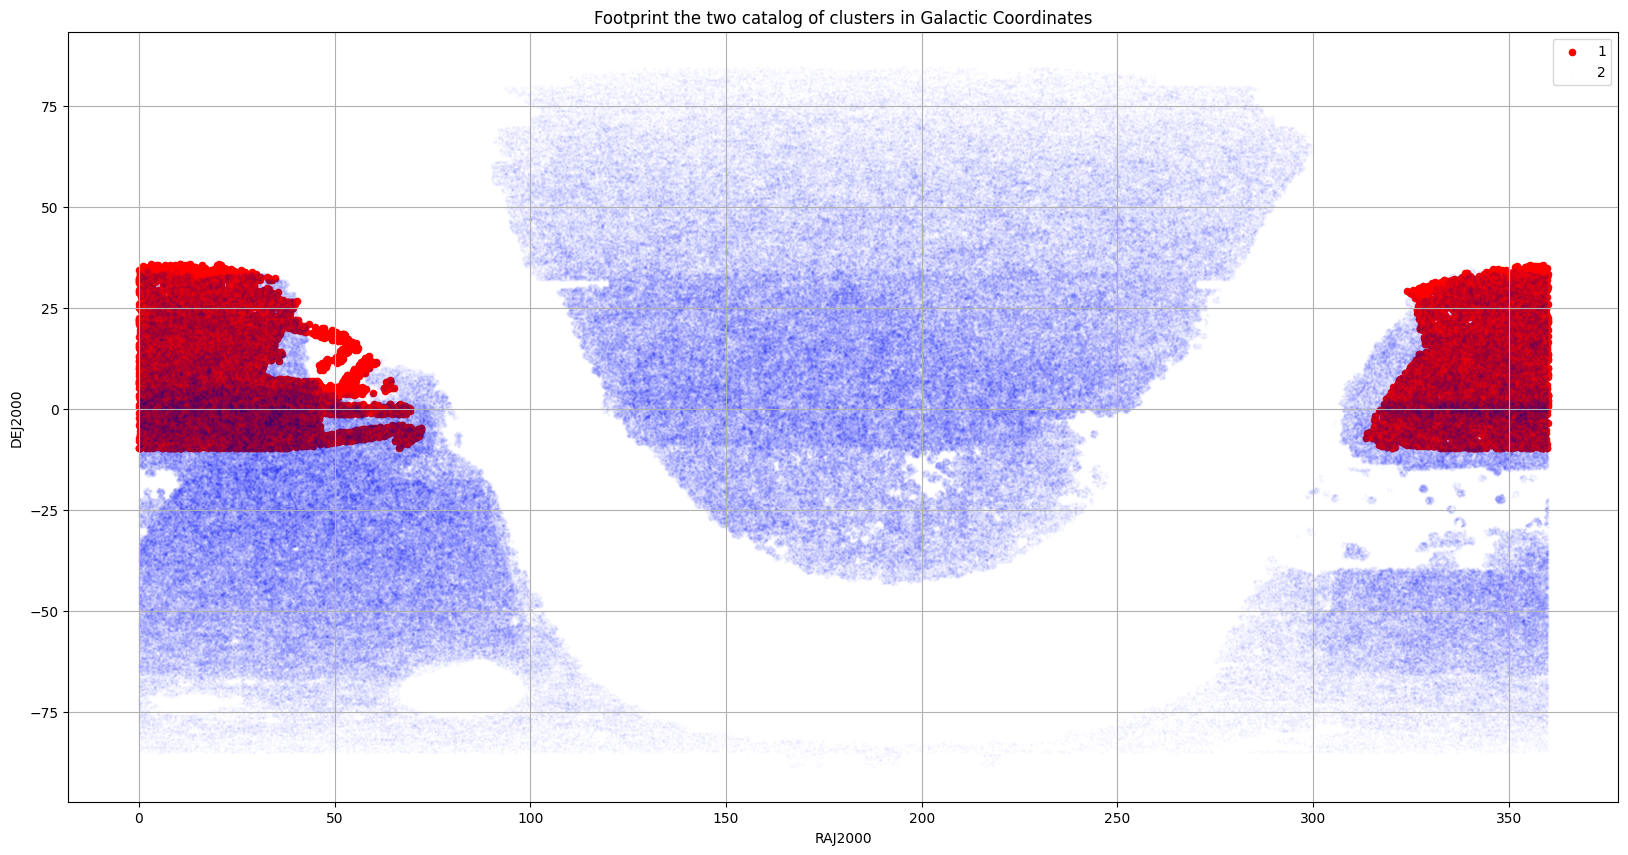

In [26]:
if NEED_TO_VIZUALISE:
    # On affiche la zone sélectionnée en coordonnées J2000 

    raj2000_1 = table_1['RAJ2000'].tolist() ; dej2000_1 = table_1['DEJ2000'].tolist()
    raj2000_2 = table_2['RAJ2000'].tolist() ; dej2000_2 = table_2['DEJ2000'].tolist()

    plt.figure(figsize=(20, 10))
    ax_projection_1 = plt.subplot(111)
    ax_projection_2 = plt.subplot(111)
    ax_projection_1_all = plt.subplot(111)
    ax_projection_2_all = plt.subplot(111)


    ax_projection_1_all.scatter(raj2000_1, dej2000_1, s=20,facecolors='red',label='1') 
    ax_projection_1_all.grid(True)
    ax_projection_1_all.set_xlabel("RAJ2000")
    ax_projection_1_all.set_ylabel("DEJ2000") 

    ax_projection_2_all.scatter(raj2000_2, dej2000_2,s=1,edgecolors='blue',alpha=0.01,label='2') 
    ax_projection_2_all.grid(True)
    ax_projection_2_all.set_xlabel("RAJ2000")
    ax_projection_2_all.set_ylabel("DEJ2000")


    plt.title(f"Footprint the two catalog of clusters in Galactic Coordinates")
    plt.legend()

## Sélection avec KDTree → POURRAIT REMPLACER MA METHODE D'ASSOCIATION (à comparer) ???

In [15]:
coords_1_galactic = np.column_stack((table_1['glon'], table_1['glat']))
coords_2_galactic = np.column_stack((table_2['glon'], table_2['glat']))

In [16]:
# Association d'éléments 1 → 2 

tree_2 = cKDTree(coords_2_galactic)

idx_1_in_2 = tree_2.query_ball_point(coords_1_galactic, r = 1)  # idx_1_in_2 → list of lists: each sublist contains the indices of matching points in tree_2 for the corresponding point in coords_1
mask_common_1 = np.array([len(match) > 0 for match in idx_1_in_2]) 

table_1_common = table_1[mask_common_1]

In [17]:
# Dans l'autre sens : 2 → 1

tree_1 = cKDTree(coords_1_galactic)

idx_2_in_1 = tree_1.query_ball_point(coords_2_galactic, r=1)
mask_common_2 = np.array([len(match) > 0 for match in idx_2_in_1])

table_2_common = table_2[mask_common_2]

In [18]:
mask_common_2

array([False, False, False, ...,  True,  True,  True], shape=(1581179,))

In [19]:
glon_1_common = table_1_common['glon'].tolist() ; glat_1_common = table_1_common['glat'].tolist()

glon_2_common = table_2_common['glon'].tolist() ; glat_2_common = table_2_common['glat'].tolist()


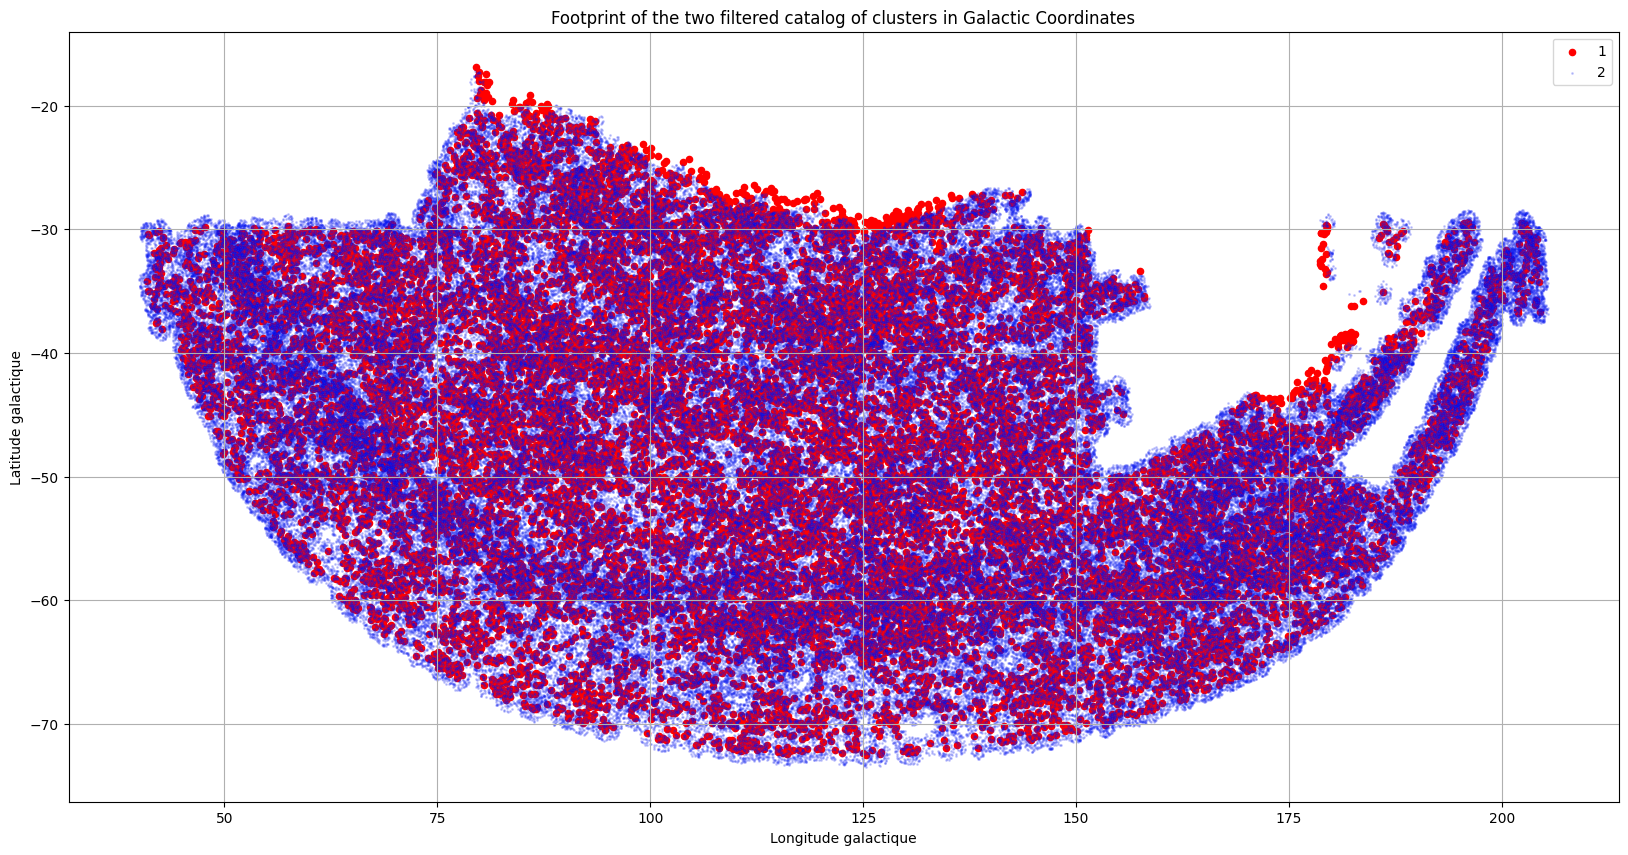

In [22]:
if NEED_TO_VIZUALISE:

    fig = plt.figure(figsize=(20, 10))
    ax_projection_1_common = plt.subplot(111)
    ax_projection_2_common = plt.subplot(111)

    ax_projection_1_common.scatter(glon_1_common, glat_1_common, s=20,facecolors='red',label='1') 
    ax_projection_1_common.grid(True)
    ax_projection_1_common.set_xlabel("Longitude galactique")
    ax_projection_1_common.set_ylabel("Latitude galactique")


    ax_projection_2_common.scatter(glon_2_common, glat_2_common,s=1,edgecolors='blue',alpha=0.2,label='2') 
    ax_projection_2_common.grid(True)
    ax_projection_2_common.set_xlabel("Longitude galactique")
    ax_projection_2_common.set_ylabel("Latitude galactique")

    plt.title(f"Footprint of the two filtered catalog of clusters in Galactic Coordinates")
    plt.legend()

# Association

Dans la suite il y aura deux types d'associations : une association 1→2 et une association 2→1. Elles différent par le point de départ de l'association : dans le cas 1→2, on prend un objet 1, on trace autour de ce point un cylindre de longueur delta_z et de rayon la tolérance angulaire, et on récupère tous les objets 2 à l'intérieur pour définir les associations : c'est l'inverse dans le 2→1. \
Pour l'association "1 → 2" : "table_1_crossed_3D" indique les proriétés des objets 1 centraux qui ont obtenu au moins une association dans 2, et "table_2_associated_3D" représente ces objets.
C'est l'inverse pour l'association "2 → 1" avec "table_2_crossed_3D" et "table_1_crossed_3D".\
Il s'avèrerait que ces méthodes ne sont pas tout à fait équivalentes (à vérifier avec la dernière cellule de cette partie qui détermine le pourcentage de différence entre le nombre des deux types d'associations).

## Détermination tolérance angulaire en fonction du redshift (inspiré du code SOPHYA de Reza)

In [ ]:
#Paramètres asssociation

skyresol_deg = 5 # découpage du ciel en degrés, pour éviter de comparer un objet à tout les autres dans le ciel, mais seulement à ceux dans la même zone (TO DO : penser à implémenter cet aspect concrètement) 
tol_ang_fixe_arcmin = 15.0 # tolérance angulaire fixe en arcminutes → UTILITé ?
min_tol_ang_arcmin = 0.5 # tolerance angulaire plancher en arcminutes (CHOI1 → eROSITA a une tolérance de 30 arcsec)
rayon_cluster_MPC = 1 # rayon du cluster (en MPC) → influence le calcule de la tolérance angulaire en fonction du redshift
delta_z = 0.010 # largeur du bin de z  (CHOI1 → DESI Legacy Imaging Surveys : incertitude de 0.010 sur le z photométrique : p.14 Wen and Han 2024)
cosmo = Planck13 # modèle cosmo utilisé : FlatLambdaCDM(name='Planck13', H0=<Quantity 67.77 km / (Mpc s)>, Om0=0.30712, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.048252)

name_indexes_crossed = 'SELECTED_0_5_arcmin__1_MPC__0_010_z.pkl' # x1 arcmin' as the minimum angular tolerance, 'x2 Mpc' as the typical cluster radius, and 'x3_z' as the redshift bin 

#Indique si on va réaliser le calcul de l'association 1→2 ou 2→1 (True) ou si on se contente de lire les indices d'associtaion précedemment calculés (False):
RUN_1_2 = False
RUN_2_1 = False

In [ ]:
def find_tol_ang_wrt_z(cosmo,z,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg):
    
    tol_ang_variable = rayon_cluster_MPC/cosmo.angular_diameter_distance(z).value # cosmo.angular_diameter_distance est en MPC donc tol_ang_variable est en radian
    tol_ang = math.radians((min_tol_ang_arcmin/60)) + tol_ang_variable   # Sûr ???

    skyresol_rad = math.radians(skyresol_deg)

    if tol_ang > skyresol_rad:
        tol_ang = skyresol_rad

    tol_ang = math.degrees(tol_ang) *3600 # Convertit en secondes d'arc
    return tol_ang 

# Détermination du nombre de bins de redshift
nb_bin_z_1 = round(table_1['zBest'].max()/delta_z,0) ; nb_bin_z_2 = round(table_2['zCl'].max()/delta_z,0)
nb_bin_z = int(max(nb_bin_z_1, nb_bin_z_2))
print(f" On va considérer {nb_bin_z} bins de redshift ({delta_z} de large)")

tol_ang_list = [] # On va y placer les tolérances angulaires pour chaque bin de redshift : on prend à chaque fois la valeur maximale du bin de redshift afin d'obtenir la tolérance angulaire la plus contraignante
for i in range(nb_bin_z):
    tol_ang_current = find_tol_ang_wrt_z(cosmo,(i+1)*delta_z,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg)
    tol_ang_list.append(tol_ang_current)
print(f"tol_ang_list : {tol_ang_list}")

# On découpe les tables en fonction des bins de redshift
table_1_list_bins = []
table_2_list_bins = [] 

def cut_table_bins_z(table,name_z,nb_bins):
    table_bins_list = []
    for i in range(nb_bins):
        z_min = i*delta_z
        z_max = (i+1)*delta_z
        table_bins = table[(table[name_z] >= z_min) & (table[name_z] <= z_max)]
        table_bins_list.append(table_bins)
    return table_bins_list 

table_1_list_bins = cut_table_bins_z(table_1,'zBest',nb_bin_z) # On découpe la table 1 en fonction des bins de redshift
table_2_list_bins = cut_table_bins_z(table_2,'zCl',nb_bin_z) # idem mais pour la table 2


 On va considérer 173 bins de redshift (0.01 de large)
tol_ang_list : [4750.32359081026, 2419.105693107137, 1642.1377023396024, 1253.732684176972, 1020.7532429192147, 865.486905993414, 754.6283217444411, 671.5248088872112, 606.9248729946745, 555.2776130963683, 513.0506337715783, 477.88900119844817, 448.16237333648706, 422.70621717565655, 400.66653908752966, 381.40284129626724, 364.42532900821664, 349.3530484994732, 335.88524475575736, 323.7813118212253, 312.84647161982815, 302.9213585533464, 293.87432116139854, 285.59564836695625, 277.9931814233724, 270.98893848938906, 264.5164892988984, 258.5188924017257, 252.94705918238992, 247.7584450752764, 242.9159940931266, 238.38728125652509, 234.14381094535491, 230.16043907061234, 226.41489430248384, 222.88737909372261, 219.56023540189491, 216.41766319226377, 213.44548224784475, 210.630929707861, 207.962487234614, 205.4297328706844, 203.02321356709663, 200.73433509387235, 198.55526662903551, 196.4788577923825, 194.49856627053387, 192.6083944886

## Association 1 → 2

### Calcul des indices

In [ ]:
# On commence par créer des listes de coordonnées (RAJ2000,DEJ2000) en récupérant les colonnes correspondantes sur les tables

liste_indexes_1 = [] # listes des indexes dans cahque bin, pour pouvoir réaliser l'association par la suite (en effet, le découpage en bin de redshift a mélangé les indices dans table_1_list_bins)
liste_coords_1 = [] # Liste de coordonnées (RAJ2000,DEJ2000) pour chaque bin de redshift
for x in table_1_list_bins:
    liste_indexes_1_bin = []
    liste_coords_1_bin = []
    for index,row in x.iterrows():
        liste_indexes_1_bin.append(index) ; liste_coords_1_bin.append((row['RAJ2000'],row['DEJ2000']))
    liste_indexes_1.append(liste_indexes_1_bin) ; liste_coords_1.append(liste_coords_1_bin)

liste_coords_2 = []
for index,row in table_2.iterrows():
    coord = (row['RAJ2000'],row['DEJ2000'])
    liste_coords_2.append(coord)


In [ ]:
# TO DO ; trouver un moyen d'accélérer le calcul ! (voir cross_matching_1_2 _tentative_accel_calcul.ipynb)

folder = '../DESI_eRass/indexes_crossed/' # Dossier de sortie pour les indices croisés
print(name_indexes_crossed) #pour rappeler quels paramètres ont été utilisés

if RUN_1_2 :
    indices_crossed = [] 
    for i in range(nb_bin_z):
        indices_crossed_current = match_celestial_objects_list_deg(liste_coords_1[i],liste_coords_2,tol_ang_list[i])
        indices_crossed.append(indices_crossed_current) 

    with open(os.path.join(folder, name_indexes_crossed), 'wb') as file:
        pickle.dump(indices_crossed, file)

SELECTED_0_5_arcmin__1_MPC__0_010_z.pkl


In [23]:
with open(os.path.join(folder, name_indexes_crossed), 'rb') as file:
    indices_crossed = pickle.load(file)

In [ ]:
# Ici, on récupères les indices des objets 1, conservés dans liste_indexes_1, pour remplacer ceux obtenus avec le cross-match dans indices_crossed (qui correpondent aux indices du bin dans lequels ils sont situés)
# En clair, on reproduit indices_crossed mais avec les "vraies" indices des objets 1 

indices_crossed_list = []

'''for i in range(nb_bin_z):
    indices_crossed_list_bin = []
    for j in range(len(indices_crossed[i])):
        k = indices_crossed[i][j][0]
        if k >= len(liste_indexes_1[i]):
            print(f"Erreur: indice {k} hors limites pour le bin {i} (taille {len(liste_indexes_1[i])})")
            print(f"indices_crossed[{i}][{j}] = {indices_crossed[i][j]}")
            continue  # ou break pour stopper
'''
for i in range(nb_bin_z):
    indices_crossed_list_bin = []
    for j in range(len(indices_crossed[i])):
        indices_crossed_list_bin.append([liste_indexes_1[i][indices_crossed[i][j][0]],indices_crossed[i][j][1]]) # le "vrai" indice 1 remplace celui qui permettait de le retrouver dans la liste des coordonnées par bin de redshift 
    indices_crossed_list.append(indices_crossed_list_bin)

# !!! bug !!! pour SELECTED_0.5_arcmin__1_MPC__0 010_z → 'IndexError: list index out of range' sur la ligne 8 : alors que ce n'est pas le cas pour les autres fichiers

In [ ]:
# Ici, on récupère les indices pour chaque association, un indice 1 est donc répété autant de fois que ce cluster est associé à un cluster 2 (si un cluster A détecté en 1 est associé à 3 clusters détectés en 2,
# il y aura 3 fois l'indices du cluster A dans la liste "indices_1_crossed_repetitifs")
indices_1_crossed_repetitifs = []
indices_2_repetitifs = []
for indices_crossed_list_bin in indices_crossed_list:
    for x in indices_crossed_list_bin :
        indices_1_crossed_repetitifs.append(x[0])
        indices_2_repetitifs.append(x[1])

# Ici, on ne garde qu'une seule occurrence de chaque cluster 1 associé à au moins un cluster 2 (si un cluster A détecté en 1 est associé à 3 clusters détectés en 2, il n'y aura tout de même qu'une seule fois l'indice
# du cluster A dans la liste "indices_1_crossed")
number_of_duplicates = 0
indices_1_crossed = set()
for indices_crossed_list_bin in indices_crossed_list:
    for float1, float2 in indices_crossed_list_bin:
        if float1 in indices_1_crossed:
            number_of_duplicates += 1
        else:
            indices_1_crossed.add(float1)
indices_1_crossed = sorted(indices_1_crossed)
print(f"Proportion de duplicats par rapport an nombre de galaxies en 1: {round(number_of_duplicates/len(table_1) * 100,3)} %")

Proportion de duplicats par rapport an nombre de galaxies en X: 308.712 %


### table_1_crossed_3D 

(Au final, on sélectionne selon la distance angulaire et on applique un seuil de z)

Si un cluster A détecté en 1 est associé à 3 clusters détectés en 2, il y aura 3 fois l'indices du cluster A dans la table "table_1_crossed_repetitifs".

In [ ]:
# Il peut y avoir plusieurs occurences d'un même objet 1 dans cette liste
table_1_crossed_repetitifs = table_1.loc[indices_1_crossed_repetitifs]
table_1_crossed_repetitifs['__indexes'] = indices_1_crossed_repetitifs
# Reorder columns to place '__indexes' at the first position
table_1_crossed_repetitifs = table_1_crossed_repetitifs[['__indexes'] + [col for col in table_1_crossed_repetitifs.columns if col != '__indexes']]

In [ ]:
# On réindice pour que les indices correpondent à l'ordre des positions dans la table
table_1_ = table_1.reset_index(drop=True)
table_2_ = table_2.reset_index(drop=True)

In [ ]:
diff_z_list_repetitif = []
dist_ang_list_repetitif = []

for i in range(len(table_1_crossed_repetitifs)):
    index_1 = indices_1_crossed_repetitifs[i] ; index_2 = indices_2_repetitifs[i]

    1_row_of_interest = table_1_crossed_repetitifs[table_1_crossed_repetitifs['__indexes'] == index_1].iloc[0] #On ne sélectionne qu'une seule ligne parmi ses éventuelles occurrences

    diff_z = abs(1_row_of_interest['zBest'] - table_2_.loc[index_2]['zCl']) 
    diff_z_list_repetitif.append(diff_z)
    dist_ang = np.sqrt((1_row_of_interest['RAJ2000'] - table_2_['RAJ2000'][index_2])**2 + (1_row_of_interest['DEJ2000'] - table_2_['DEJ2000'][index_2])**2)
    dist_ang_list_repetitif.append(dist_ang)
    
table_1_crossed_repetitifs['id_asso_2'] = indices_2_repetitifs
table_1_crossed_repetitifs['diff_z'] = diff_z_list_repetitif
table_1_crossed_repetitifs['dist_ang'] = dist_ang_list_repetitif

Tout l'intéret de récupérer ce dataframe "table_1_crossed_repetitifs" est de pouvoir lui appliquer un seuil pour "diff_z" : en effet, l'association faite avec la fonction 'match_celestial_objects_list_deg' ne se basait que sur la distance angulaire entre les clusters. En appliquant ce seuil sur le redshift, on passe d'un cross-matching "2D" à "3D".

In [ ]:
# On applique le seuil de redshift pour ne conserver que les assocciations qui ne sont pas trop éloignées en redshift

table_1_crossed_3D = table_1_crossed_repetitifs[table_1_crossed_repetitifs['diff_z'] < delta_z]
print(np.round(100-(len(table_1_crossed_3D)/len(table_1_crossed_repetitifs))*100,1), " % des associations sont éliminées par le critère de redshift") 

table_2_associated_3D = table_2_.loc[table_1_crossed_3D['id_asso_2']]
table_2_associated_3D['id_asso_1'] = table_1_crossed_3D['__indexes'].tolist()

87.4  % des associations sont éliminées par le critère de redshift


In [33]:
associations = []
for index,x in table_1_crossed_3D.iterrows():
    current_asso = [0,0]
    current_asso[0] = int(x['__indexes']) ; current_asso[1] = int(x['id_asso_2'])
    associations.append(current_asso)

table_1_crossed_3D['id_associations'] = associations ; table_2_associated_3D['id_associations'] = associations

NameError: name 'table_1_crossed_3D' is not defined

In [ ]:
# Sélection zone fiduciaire (pour éviter d'avoir des objets 1 dont l'association 2 a été précédemment filtrée ←→ séparation de couples)

seuil_fiduciaire = 1 
radius_ = radius + seuil_fiduciaire ; borne_1_glat_ = borne_1_glat - seuil_fiduciaire ; borne_2_glat_ = borne_2_glat + seuil_fiduciaire ; min_glon = min_glon + seuil_fiduciaire

table_1_crossed_3D['distance'] = np.sqrt((table_1_crossed_3D['glon'] - x_center)**2 + (table_1_crossed_3D['glat'] - y_center)**2)
table_1_crossed_3D = table_1_crossed_3D[table_1_crossed_3D['distance'] >= radius_]
table_1_crossed_3D = table_1_crossed_3D.drop(columns=['distance'])




table_1_crossed_3D = table_1_crossed_3D[(table_1_crossed_3D['glon'] > min_glon)
                                    & ((table_1_crossed_3D['glat'] <= borne_1_glat_) | (table_1_crossed_3D['glat']>= borne_2_glat_))
                                    ]


table_2_associated_3D = table_2_associated_3D[table_2_associated_3D['id_associations'].isin(table_1_crossed_3D['id_associations'].tolist())] # On ne conserve ques les associations dont les objets 1 sont dans la zone fiduciaire : cela permet d'éviter 
                                                                                                                                                               # la séparation de couples (si le 'seuil_fiduciaire' est assez grand)

'''table_2_associated_3D_ = table_2_associated_3D_.loc[table_1_crossed_3D_['id_asso_2']]
print(len(table_2_associated_3D_))
table_2_associated_3D_ = table_2_associated_3D_[table_2_associated_3D_['id_asso_1'].isin(table_1_crossed_3D_['__indexes'].tolist())]
print(len(table_2_associated_3D_))'''


NameError: name 'radius' is not defined

In [ ]:
glon_2_associated_3D = table_2_associated_3D['glon'].tolist() ; glat_2_associated_3D = table_2_associated_3D['glat'].tolist()
glon_1_crossed_3D = table_1_crossed_3D['glon'].tolist() ; glat_1_crossed_3D = table_1_crossed_3D['glat'].tolist()


fig = plt.figure(figsize=(20, 10))
'''ax_projection_1 = plt.subplot(111)
ax_projection_2 = plt.subplot(111)'''
ax_projection_1_ = plt.subplot(111)
ax_projection_2_ = plt.subplot(111)


ax_projection_2_.scatter(glon_2_associated_3D, glat_2_associated_3D,s=1,edgecolors='red',facecolors='none',label='2') 
ax_projection_2_.grid(True)
ax_projection_2_.set_xlabel("Longitude galactique")
ax_projection_2_.set_ylabel("Latitude galactique")

ax_projection_1_.scatter(glon_1_crossed_3D, glat_1_crossed_3D, s=20,facecolors='blue',alpha=0.2,label='1') 
ax_projection_1_.grid(True)
ax_projection_1_.set_xlabel("Longitude galactique")
ax_projection_1_.set_ylabel("Latitude galactique")


plt.title(f"Footprint of 1 and their associated 2 Clusters in Galactic Coordinates in the filtered area")
plt.legend()


NameError: name 'table_2_associated_3D' is not defined

In [ ]:
table_1_crossed_3D

__indexes        glon       glat    _RAJ2000   _DEJ2000  \
2552        2552  209.634369 -50.384357   55.048567 -18.579460   
3833        3833  200.416033 -33.239623   67.917806  -5.084819   
4370        4370  201.358652 -27.735914   73.130685  -3.105706   
8094        8094  269.583941  26.491612  159.165881 -27.515430   
9528        9528  302.405192  21.557974  192.207279 -41.311106   
...          ...         ...        ...         ...        ...   
4854        4854  235.223044 -33.386823   78.775357 -32.194606   
5480        5480  249.285537 -29.529085   86.669145 -43.138769   
11648      11648  337.381518 -40.221721  316.517336 -58.740395   
3992        3992  260.902174 -41.204962   69.513577 -52.915845   
840          840  266.066668 -69.175450   29.755758 -42.791252   

                          Name     RAJ2000    DEJ2000         Exp   zBest  \
2552   1eRASS J034011.6-183446   55.048567 -18.579460  221.399994  0.0056   
3833   1eRASS J043140.2-050505   67.917806  -5.084819  146.399994  0.0160   
4370   1eRASS J045231.3-030620   73.130685  -3.105706  137.600006  0.0148   
8094   1eRASS J103639.8-273055  159.165881 -27.515430  104.500000  0.0114   
9528   1eRASS J124849.7-411839  192.207279 -41.311106  177.699997  0.0110   
...                        ...         ...        ...         ...     ...   
4854   1eRASS J051506.0-321140   78.775357 -32.194606  209.000000  1.0929   
5480   1eRASS J054640.5-430819   86.669145 -43.138769  262.100006  1.1281   
11648  1eRASS J210604.1-584425  316.517336 -58.740395   98.300003  1.1263   
3992   1eRASS J043803.2-525457   69.513577 -52.915845  542.099976  1.1774   
840    1eRASS J015901.3-424728   29.755758 -42.791252  145.800003  1.2192   

       ...    KT      Mgas500   YX500       M500  Fgas500        R500  \
2552   ...   NaN          NaN     NaN        NaN      NaN -2147483648   
3833   ...   NaN          NaN     NaN        NaN      NaN -2147483648   
4370   ...   NaN          NaN     NaN        NaN      NaN -2147483648   
8094   ...  3.10    74.360001  231.18  15.840000    0.047         820   
9528   ...  3.19   194.779999  623.62  26.990000    0.073         979   
...    ...   ...          ...     ...        ...      ...         ...   
4854   ...   NaN          NaN     NaN        NaN      NaN -2147483648   
5480   ...  2.07   228.070007  484.77  26.879999    0.078         640   
11648  ...   NaN  1137.420044    0.00  73.830002    0.153         898   
3992   ...   NaN   232.119995    0.00  20.240000    0.115         572   
840    ...   NaN          NaN     NaN        NaN      NaN -2147483648   

       id_asso_opt  diff_z  dist_ang  id_associations  
2552        801100  0.0086  0.000999   [2552, 801100]  
3833        240111  0.0004  0.002128   [3833, 240111]  
4370        819392  0.0001  0.001053   [4370, 819392]  
8094        441160  0.0021  0.017430   [8094, 441160]  
9528        567180  0.0045  0.317038   [9528, 567180]  
...            ...     ...       ...              ...  
4854        823507  0.0081  0.022545   [4854, 823507]  
5480        828251  0.0039  0.018838   [5480, 828251]  
11648       698902  0.0048  0.007115  [11648, 698902]  
3992        815954  0.0044  0.012338   [3992, 815954]  
840          73439  0.0068  0.046332     [840, 73439]  

[5912 rows x 29 columns]

### table_1_crossed [DEPRECATED] (TO DO mettre à jour avec zone fiduciaire) 
Si un cluster A détecté en 1 est associé à 3 clusters détectés en 2, il n'y aura tout de même qu'une seule fois l'indice du cluster A dans la table "table_1_crossed" (pas de seuil sur la différence de z, association uniquement '2D').

In [26]:
#Pour chaque objet 1, on va identifier le nombre d'objets 2s associés, aisni que les indices de ces objets 2

associations_dict_1 = {}
for x in indices_1_crossed:
    associations_dict_1[x] = []
    for i in range(nb_bin_z):
        for float1, float2 in indices_crossed_list[i]:
            if float1 == x:
                associations_dict_1[x].append(float2)

#Maintenant, on va ajouter à chaque objet 1 le nombre d'objets 2 associés
for x in indices_1_crossed:
    num_associations = len(associations_dict_1[x])
    associations_dict_1[x] = (associations_dict_1[x], num_associations)

#On obtient un dictionnaire de la forme {indice_1 : (indices_objets_2, nombre_objets_2_associés)}
'''print("Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_2s_associées),nombres d'objets dans 2 associé) : ",'\n' )
associations_dict_1'''
            

NameError: name 'indices_1_crossed' is not defined

Maintenant, on récupère dans la table 1 les objets qui ont une association :

In [ ]:
table_1_crossed = table_1.loc[indices_1_crossed] #; table_1_crossed = table_1_crossed.reset_index(drop=True) # On reset l'index pour ne pas avoir de mismacth dans les calculs par la suite
#table_2_crossed = ta<<dble_2.iloc[indices_2_crossed] ; table_2_crossed = table_2_crossed.reset_index(drop=True)

In [ ]:
#On calcule les informations d'associations "diff_z" et "dist_ang" pour chaque objet 1

diff_z_list = [] # Liste qui va contenir les différences de redshift entre l'objet 1 et l'ensemble des objets 2 associés
dist_ang_list = [] # Liste qui va contenir les distances angulaires entre l'objet 1 et l'ensemble des objets 2 associés
for index, x in table_1_crossed.iterrows():
    obj_2_ass = associations_dict_1[index][0] #liste des objets 2 associés à l'objet 1 courant
    diff_z = []
    dist_ang = []
    for j in range(len(obj_2_ass)): # On parcourt la liste des objets 2 associés à l'objet 1
        diff_z.append(abs(table_1_crossed['zBest'][index] - table_2_['zCl'][obj_2_ass[j]]))
        dist_ang.append(np.sqrt((table_1_crossed['RAJ2000'][index] - table_2_['RAJ2000'][obj_2_ass[j]])**2 + (table_1_crossed['DEJ2000'][index] - table_2_['DEJ2000'][obj_2_ass[j]])**2)) 
    diff_z_list.append(diff_z) # On ajoute la liste des différences de redshift à la liste diff_z_list
    dist_ang_list.append(dist_ang)
    #print(f"Index: {index}, Element: {x}")
    #print(associations_dict_1[i])
    # print(associations_dict_1[index])
    #print(associations_dict_1[index][0][j])
    """diff_z.append(abs(table_1_crossed['zBest'][i] - table_2['Z'][associations_dict_1[i][0]]))
    diff_z_list.append(diff_z)"""

In [ ]:
# On ajoute les informations d'associations à table_1_crossed. En comparaison de ce qu'a fait Reza on a : Nb_assos <-> idm ; id_assos <-> idass ; diff_z <-> delz ; dist_ang <-> dstass  

#Nb_assos :
nb_assos_list = [x[1][1] for x in associations_dict_1.items()]
table_1_crossed['nb_assos'] = nb_assos_list

#id_assos :
id_assos_list = [x[1][0] for x in associations_dict_1.items()]
table_1_crossed['id_assos'] = id_assos_list

#diff_z
table_1_crossed['diff_z'] = diff_z_list

#dist_ang
table_1_crossed['dist_ang'] = dist_ang_list


NameError: name 'associations_dict_X' is not defined

In [ ]:
# On crée la table "2 associée" en ne conservant que les objets 2 associés à un objet 1

'flattened_list = [item for sublist in nested_list for item in sublist]'
id_assos_list_flatten = [id_assos for sublist in id_assos_list for id_assos in sublist] # On 'flatten' id_assos_list
table_2_associated = table_2.iloc[id_assos_list_flatten]

In [ ]:
# TO DO Sélection zone fiduciaire (comme pour table_1_crossed_3D) : problème ici la colonne 'id_assos' de table_1_crossed est une liste de listes

'''table_1_crossed['distance'] = np.sqrt((table_1_crossed['glon'] - x_center)**2 + (table_1_crossed['glat'] - y_center)**2)
table_1_crossed = table_1_crossed[table_1_crossed['distance'] >= radius_]
table_1_crossed = table_1_crossed.drop(columns=['distance'])



table_1_crossed = table_1_crossed[(table_1_crossed['glon'] > min_glon)
                                    & ((table_1_crossed['glat'] >= borne_1_glat_) | (table_1_crossed['glat'] <= borne_2_glat_))
                                    ]


table_2_associated = table_2_associated.loc[table_1_crossed['id_asso']]'''

"table_1_crossed['distance'] = np.sqrt((table_1_crossed['glon'] - x_center)**2 + (table_1_crossed['glat'] - y_center)**2)\ntable_1_crossed = table_1_crossed[table_1_crossed['distance'] >= radius_]\ntable_1_crossed = table_1_crossed.drop(columns=['distance'])\n\n\n\ntable_1_crossed = table_1_crossed[(table_1_crossed['glon'] > min_glon)\n                                    & ((table_1_crossed['glat'] >= borne_1_glat_) | (table_1_crossed['glat'] <= borne_2_glat_))\n                                    ]\n\n\ntable_optique_associated = table_optique_associated.loc[table_1_crossed['id_asso']]"

In [ ]:
table_1_crossed

glon       glat    _RAJ2000   _DEJ2000                     Name  \
0      342.749448 -74.271284    0.021730 -38.624903  1eRASS J000005.2-383729   
1      304.840936 -34.106231    0.089191 -82.831715  1eRASS J000021.4-824954   
2      322.452378 -65.003242    0.129422 -50.151013  1eRASS J000031.0-500903   
3      312.522364 -53.144800    0.132712 -63.025286  1eRASS J000031.8-630131   
4      327.067389 -68.286560    0.189080 -46.394874  1eRASS J000045.3-462341   
...           ...        ...         ...        ...                      ...   
12241  314.228009 -55.350263  359.741833 -60.612333  1eRASS J235858.0-603644   
12242  317.972769 -60.279763  359.799123 -55.296727  1eRASS J235911.7-551748   
12243  357.004161 -76.739220  359.864701 -34.306012  1eRASS J235927.5-341821   
12244  330.823690 -70.028243  359.980381 -44.205215  1eRASS J235955.2-441218   
12245  340.618742 -73.658436  359.983837 -39.473995  1eRASS J235956.1-392826   

          RAJ2000    DEJ2000         Exp   zBest  e_zBest  ...    KT  \
0        0.021730 -38.624903   94.800003  0.3153   0.0079  ...  1.90   
1        0.089191 -82.831715  184.199997  0.0891   0.0002  ...   NaN   
2        0.129422 -50.151013  117.300003  0.0681   0.0002  ...  1.79   
3        0.132712 -63.025286  139.600006  0.2448   0.0058  ...   NaN   
4        0.189080 -46.394874  109.500000  0.0925   0.0004  ...  0.96   
...           ...        ...         ...     ...      ...  ...   ...   
12241  359.741833 -60.612333  142.500000  0.1052   0.0064  ...   NaN   
12242  359.799123 -55.296727  130.800003  0.2137   0.0063  ...   NaN   
12243  359.864701 -34.306012   87.500000  0.1138   0.0004  ...   NaN   
12244  359.980381 -44.205215   98.099998  0.5797   0.0117  ...   NaN   
12245  359.983837 -39.473995   93.000000  0.1024   0.0004  ...  4.18   

          Mgas500   YX500       M500  Fgas500  R500  nb_assos  \
0      279.160004  553.19  36.070000    0.075   971         2   
1      111.919998    0.00  16.990000    0.065   819         6   
2        1.920000    9.34   3.630000    0.009   493         8   
3      171.949997    0.00  22.040001    0.076   846         6   
4        6.400000   11.17   3.780000    0.019   495         8   
...           ...     ...        ...      ...   ...       ...   
12241  358.950012    0.00  38.669998    0.093  1071         9   
12242    5.590000    0.00   8.150000    0.008   614         3   
12243   81.230003    0.00  14.110000    0.054   763         4   
12244   41.310001    0.00  25.920000    0.020   785         1   
12245  192.529999  793.02  27.010000    0.071   951         9   

                                                id_assos  \
0                                           [27, 761190]   
1             [351, 780, 759043, 759730, 759795, 761006]   
2           [37, 95, 267, 368, 403, 686, 760839, 761055]   
3                       [17, 232, 312, 454, 549, 761218]   
4            [281, 369, 396, 475, 564, 758, 830, 761199]   
...                                                  ...   
12241  [760377, 760418, 760449, 760497, 760656, 76107...   
12242                           [760745, 760895, 761028]   
12243                       [12, 760908, 760949, 761041]   
12244                                           [761124]   
12245  [18, 110, 135, 221, 292, 760929, 761031, 76114...   

                                                  diff_z  \
0            [0.003399987792968684, 0.09009998779296868]   
1      [0.0029000032424926075, 0.9065999967575075, 0....   
2      [0.4808000020623209, 0.6743000020623208, 0.020...   
3      [1.0079999986171722, 0.43289999861717227, 0.26...   
4      [0.9199999988079071, 0.011699998807907105, 0.8...   
...                                                  ...   
12241  [1.0618999998927117, 0.40649999989271174, 0.40...   
12242  [0.00010000352859498851, 0.162300003528595, 0....   
12243  [0.30700000332593924, 0.1053000033259392, 0.20...   
12244                              [0.40150000686645504]   
12245  [0.546600002586841

## Association 2 → 1

On utilise les mêmes paramètres que pour l'association 1→2 : il s'avère que l'association 2→1 (en tout cas pour les paramètres 30''/1 MPC/0.010 z) n'est pas équivalente à celle 1→2 : voir la différence de nombre d'associations à la fin, on retrouve une différenc de quelques % voire inférieure à 1%.

### Calcul des indices

In [ ]:
# On commence par créer des listes de coordonnées (RAJ2000,DEJ2000) en récupérant les colonnes correspondantes sur les tables

liste_indexes_2_bins = []
liste_coords_2_bins = []
for x in table_2_list_bins:
    liste_indexes_2_bin = []
    liste_coords_2_bin = []
    for index,row in x.iterrows():         
        liste_indexes_2_bin.append(index) ; liste_coords_2_bin.append((row['RAJ2000'],row['DEJ2000']))
    liste_indexes_2_bins.append(liste_indexes_2_bin) ; liste_coords_2_bins.append(liste_coords_2_bin)

liste_coords_1_all = [] #Au contraire de liste_indexes_1, cette liste d'indexes ne sera pas coupé par bin de redshift
for index,row in table_1.iterrows():
    coord = (row['RAJ2000'],row['DEJ2000'])
    liste_coords_1_all.append(coord)

In [ ]:
# TO DO ; trouver un moyen d'accélérer le calcul ! (voir cross_matching_1_2 _tentative_accel_calcul.ipynb)

folder_2_1 = '../DESI_eRass/indexes_crossed_2_1/' # Dossier de sortie pour les indices croisés
print(name_indexes_crossed) #pour rappeler quels paramètres ont été utilisés

if RUN_2_1 :
    indices_crossed_2_1 = [] 
    for i in range(nb_bin_z):
        indices_crossed_2_1_current = match_celestial_objects_list_deg(liste_coords_2_bins[i],liste_coords_1_all,tol_ang_list[i])
        indices_crossed_2_1.append(indices_crossed_2_1_current)

        with open(os.path.join(folder_2_1, name_indexes_crossed), 'wb') as file:
            pickle.dump(indices_crossed_2_1, file)

#REMARQUE : Le calcul semble bcp plus rapide que dans le sens 1→2 ! Avec les params  0.5 arcmin | 1 MPc | 0.010 deltaz :  2m30 dans le sens 2→1 contre 1h30 dans le sens 1→2

SELECTED_0_5_arcmin__1_MPC__0_010_z.pkl


In [ ]:
with open(os.path.join(folder_2_1, name_indexes_crossed), 'rb') as file:
    indices_crossed_2_1 = pickle.load(file)

In [ ]:
indices_crossed_2_1_list = []

for i in range(nb_bin_z):
    indices_crossed_2_1_list_bin = []
    for j in range(len(indices_crossed_2_1[i])):
        indices_crossed_2_1_list_bin.append([liste_indexes_2_bins[i][indices_crossed_2_1[i][j][0]],indices_crossed_2_1[i][j][1]]) # le "vrai" indice 1 remplace celui qui permettait de le retrouver dans la liste des coordonnées par bin de redshift 
    indices_crossed_2_1_list.append(indices_crossed_2_1_list_bin)


In [ ]:
# Ici, on récupère les indices pour chaque association, un indice 2 est donc répété autant de fois que ce cluster est associé à un cluster 1 (si un cluster A détecté en 2 est associé à 3 clusters détectés en 1,
# il y aura 3 fois l'indices du cluster A dans la liste "indices_2_crossed_repetitifs")
indices_2_crossed_repetitifs = []
indices_1_repetitifs = []
for indices_crossed_2_1_list_bin in indices_crossed_2_1_list:
    for x in indices_crossed_2_1_list_bin :
        indices_2_crossed_repetitifs.append(x[0])
        indices_1_repetitifs.append(x[1])   

In [34]:
# Ici, on ne garde qu'une seule occurrence de chaque cluster 2 associé à au moins un cluster 1 (si un cluster A détecté en 2 est associé à 3 clusters détectés en 1, il n'y aura tout de même qu'une seule fois l'indice
# du cluster A dans la liste "indices_2_crossed")
number_of_duplicates_2 = 0
indices_2_crossed = set()
for indices_crossed_2_1_list_bin in indices_crossed_2_1_list:
    for float1, float2 in indices_crossed_2_1_list_bin:
        if float1 in indices_2_crossed:
            number_of_duplicates_2 += 1
        else:
            indices_2_crossed.add(float1)
indices_2_crossed = sorted(indices_2_crossed)
print(f"Proportion de duplicats par rapport an nombre de galaxies en 2: {round(number_of_duplicates_2/len(table_1) * 100,3)} %")

NameError: name 'indices_crossed_2_1_list' is not defined

In [ ]:
len(indices_2_crossed_repetitifs)

16965

In [ ]:
len(indices_1_crossed_repetitifs)

47612

### table_2_crossed_3D

In [ ]:
# Il peut y avoir plusieurs occurences d'un même objet 1 dans cette liste
table_2_crossed_repetitifs = table_2.loc[indices_2_crossed_repetitifs]
table_2_crossed_repetitifs['__indexes'] = indices_2_crossed_repetitifs
# Reorder columns to place '__indexes' at the first position
table_2_crossed_repetitifs = table_2_crossed_repetitifs[['__indexes'] + [col for col in table_2_crossed_repetitifs.columns if col != '__indexes']]

In [35]:
# On réindice pour que les indices correpondent à l'ordre des positions dans la table
table_1_ = table_1.reset_index(drop=True)
table_2_ = table_2.reset_index(drop=True)

diff_z_list_repetitif = []
dist_ang_list_repetitif = []

for i in range(len(table_2_crossed_repetitifs)):
    index_2 = indices_2_crossed_repetitifs[i] ; index_1 = indices_1_repetitifs[i]

    Opt_row_of_interest = table_2_crossed_repetitifs[table_2_crossed_repetitifs['__indexes'] == index_2].iloc[0] #On ne sélectionne qu'une seule ligne parmi ses éventuelles occurrences

    diff_z = abs(Opt_row_of_interest['zCl'] - table_1_.loc[index_1]['zBest']) 
    diff_z_list_repetitif.append(diff_z)
    dist_ang = np.sqrt((Opt_row_of_interest['RAJ2000'] - table_1_['RAJ2000'][index_1])**2 + (Opt_row_of_interest['DEJ2000'] - table_1_['DEJ2000'][index_1])**2)
    dist_ang_list_repetitif.append(dist_ang)
    
table_2_crossed_repetitifs['id_asso_1'] = indices_1_repetitifs
table_2_crossed_repetitifs['diff_z'] = diff_z_list_repetitif
table_2_crossed_repetitifs['dist_ang'] = dist_ang_list_repetitif

# On applique le seuil de redshift pour ne conserver que les assocciations qui ne sont pas trop éloignées en redshift
table_2_crossed_3D = table_2_crossed_repetitifs[table_2_crossed_repetitifs['diff_z'] < delta_z]
print(np.round((1-(len(table_2_crossed_3D)/len(table_2_crossed_repetitifs)))*100,1), " % des associations sont éliminées par le critère de redshift") 

#O récupère dans une table "table_1_associated_3D" les objets 1 associés à un objet 2
table_1_associated_3D = table_1_.loc[table_2_crossed_3D['id_asso_1']]
table_1_associated_3D['id_asso_2'] = table_2_crossed_3D['__indexes'].tolist()

associations_2_1 = []
for index,x in table_2_crossed_3D.iterrows():
    current_asso = [0,0]
    current_asso[0] = int(x['__indexes']) ; current_asso[1] = int(x['id_asso_1'])
    associations_2_1.append(current_asso)

table_2_crossed_3D['id_associations'] = associations_2_1 ; table_1_associated_3D['id_associations'] = associations_2_1


# Sélection zone fiduciaire (pour éviter d'avoir des objets 2 dont l'association 1 a été précédemment filtrée ←→ séparation de couples)

seuil_fiduciaire = 1 
radius_ = radius + seuil_fiduciaire ; borne_1_glat_ = borne_1_glat - seuil_fiduciaire ; borne_2_glat_ = borne_2_glat + seuil_fiduciaire ; min_glon = min_glon + seuil_fiduciaire

table_2_crossed_3D['distance'] = np.sqrt((table_2_crossed_3D['glon'] - x_center)**2 + (table_2_crossed_3D['glat'] - y_center)**2)
table_2_crossed_3D = table_2_crossed_3D[table_2_crossed_3D['distance'] >= radius_]
table_2_crossed_3D = table_2_crossed_3D.drop(columns=['distance'])



table_2_crossed_3D = table_2_crossed_3D[(table_2_crossed_3D['glon'] > min_glon)
                                    & ((table_2_crossed_3D['glat'] <= borne_1_glat_) | (table_2_crossed_3D['glat']>= borne_2_glat_))
                                    ]


table_1_associated_3D = table_1_associated_3D[table_1_associated_3D['id_associations'].isin(table_2_crossed_3D['id_associations'].tolist())] # On ne conserve ques les associations dont les objets 2 sont dans la zone fiduciaire : cela permet d'éviter 
                                                                                                                                               # la séparation de couples (si le 'seuil_fiduciaire' est assez grand)

NameError: name 'table_2_crossed_repetitifs' is not defined

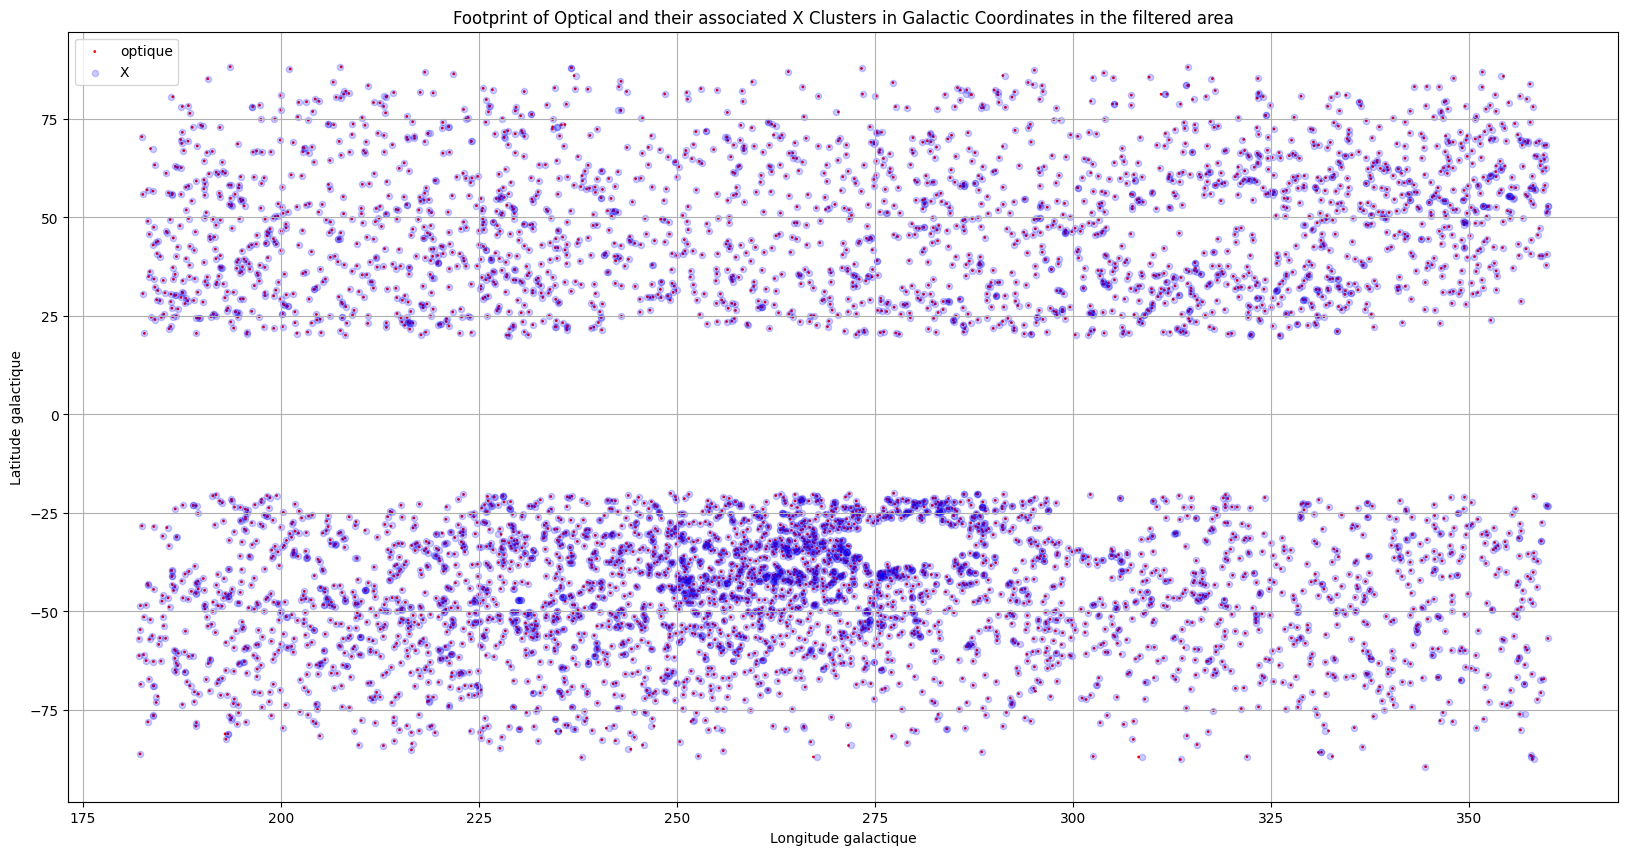

In [ ]:
glon_1_associated_3D = table_1_associated_3D['glon'].tolist() ; glat_1_associated_3D = table_1_associated_3D['glat'].tolist()
glon_2_crossed_3D = table_2_crossed_3D['glon'].tolist() ; glat_2_crossed_3D = table_2_crossed_3D['glat'].tolist()


fig = plt.figure(figsize=(20, 10))
'''ax_projection_1 = plt.subplot(111)
ax_projection_2 = plt.subplot(111)'''
ax_projection_1_ = plt.subplot(111)
ax_projection_2_ = plt.subplot(111)


ax_projection_2_.scatter(glon_2_crossed_3D, glat_2_crossed_3D,s=1,edgecolors='red',facecolors='none',label='2') 
ax_projection_2_.grid(True)
ax_projection_2_.set_xlabel("Longitude galactique")
ax_projection_2_.set_ylabel("Latitude galactique")

ax_projection_1_.scatter(glon_1_associated_3D, glat_1_associated_3D, s=20,facecolors='blue',alpha=0.2,label='1') 
ax_projection_1_.grid(True)
ax_projection_1_.set_xlabel("Longitude galactique")
ax_projection_1_.set_ylabel("Latitude galactique")


plt.title(f"Footprint of Optical and their associated 1 Clusters in Galactic Coordinates in the filtered area")
plt.legend()

In [36]:
if len(table_2_crossed_3D) == len(table_1_crossed_3D):
    print("On a le même nombre d'associations dans le cas où on centre l'association autour d'un objet central 1 ou 2")
else :
    print("On a pas le même nombre d'associations dans le cas où on centre l'association autour d'un objet central 1 ou 2\n")
    print("Pourcentage de différence entre la méthode 1→2 et la méthode 2→1 : ",round((1-(len(table_2_crossed_3D)/len(table_1_crossed_3D)))*100,1), " %")


NameError: name 'table_2_crossed_3D' is not defined

# Visualisation résultats associations 

In [ ]:
index_2_associated_3D = table_2_associated_3D.index.tolist()
table_2_associated_3D['__indexes'] = index_2_associated_3D
table_2_associated_3D = table_2_associated_3D[['__indexes'] + [col for col in table_2_associated_3D.columns if col != '__indexes']]
table_2_associated_3D

__indexes        glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
801100     801100  209.635642 -50.383836   55.04938 -18.58004  1065735          
240111     240111  200.416500 -33.241710   67.91617  -5.08618   329686    WH-   
819392     819392  201.358589 -27.736965   73.12974  -3.10617  1084027    WH-   
441160     441160  269.571465  26.480843  159.14868 -27.51825   530798    WH-   
567180     567180  302.655197  21.489060  192.51630 -41.38195   657420    WH-   
...           ...         ...        ...        ...       ...      ...    ...   
823507     823507  235.229261 -33.405857   78.75488 -32.20404  1088142    WH-   
828251     828251  249.298715 -29.519147   86.68547 -43.14817  1092886    WH-   
698902     698902  337.373813 -40.222681  316.52188 -58.74587   827614          
815954     815954  260.915480 -41.199667   69.51971 -52.92655  1080589    WH-   
73439       73439  266.170848 -69.180995   29.71560 -42.81436   143249    WH-   

                    Name    RAJ2000   DEJ2000  ...  lam500  M500  Ngal  Gamma  \
801100  J034011.9-183448   55.04938 -18.58004  ...   25.88  11.8     6    0.0   
240111  J043139.9-050510   67.91617  -5.08618  ...   12.46   5.8     9    0.0   
819392  J045231.1-030622   73.12974  -3.10617  ...   10.86   5.1     9    0.0   
441160  J103635.7-273106  159.14868 -27.51825  ...   21.93  10.0    20    0.0   
567180  J125003.9-412255  192.51630 -41.38195  ...   38.90  17.5    23    0.0   
...                  ...        ...       ...  ...     ...   ...   ...    ...   
823507  J051501.2-321215   78.75488 -32.20404  ...   11.69   5.4     7    0.0   
828251  J054644.5-430853   86.68547 -43.14817  ...   30.27  13.7     7    0.0   
698902  J210605.3-584445  316.52188 -58.74587  ...   34.87  15.7    20    0.0   
815954  J043804.7-525536   69.51971 -52.92655  ...   24.00  10.9     9    0.0   
73439   J015851.7-424852   29.71560 -42.81436  ...   10.11   4.7     6    0.0   

        e_Gamma  imag_        Cat    recno  id_asso_X  id_associations  
801100      0.0      2  CFSFDP     1065735       2552   [2552, 801100]  
240111      0.0      1              329686       3833   [3833, 240111]  
819392      0.0      2             1084027       4370   [4370, 819392]  
441160      0.0      1              530798       8094   [8094, 441160]  
567180      0.0      1              657420       9528   [9528, 567180]  
...         ...    ...        ...      ...        ...              ...  
823507      0.0      2             1088142       4854   [4854, 823507]  
828251      0.0      2             1092886       5480   [5480, 828251]  
698902      0.0      1  WH22        827614      11648  [11648, 698902]  
815954      0.0      2             1080589       3992   [3992, 815954]  
73439       0.0      1              143249        840     [840, 73439]  

[5912 rows x 26 columns]

In [ ]:
table_2_associated_3D.columns

Index(['__indexes', 'glon', 'glat', '_RAJ2000', '_DEJ2000', 'ID', 'n_Name',
       'Name', 'RAJ2000', 'DEJ2000', 'zCl', 'f_zCl', 'zmag', 'W1mag', 'logMs',
       'r500', 'lam500', 'M500', 'Ngal', 'Gamma', 'e_Gamma', 'imag_', 'Cat',
       'recno', 'id_asso_X', 'id_associations'],
      dtype='object')

In [21]:
table_1_crossed_3D.columns

NameError: name 'table_1_crossed_3D' is not defined

In [49]:
# Dossier où stocker les plots
folder_plots = f"../DESI_eRass/figures/{name_indexes_crossed}/"
os.makedirs(folder_plots, exist_ok=True)

In [ ]:
# Quantités intéressantes

diff_z = table_1_crossed_3D['diff_z'] # Différence de redshift entre l'objet 1 et l'objet 2 associé
indexes_1_crossed_3D = table_1_crossed_3D['__indexes'] 

#Optique
N_gal = table_2_associated_3D['Ngal']
richness = table_2_associated_3D['lam500'] # Richness : mass proxy → define eq 2 in Wen 2024
M_500_2 = np.array(table_2_associated_3D['M500'])


#1
M500_1 = np.array(table_1_crossed_3D['M500'])
kT_1 = np.array(table_1_crossed_3D['KT']) #Temperature en keV
CR500_1 = np.array(table_1_crossed_3D['CR500']) # Count Rate en counts/s depuis la sphère de rayon R500
dz_x_mean = table_1_crossed_3D['e_zBest'].mean() # moyenne des erreurs de redshift des objets 1

In [40]:
nb_nan_M_500_1 = table_1_crossed_3D["M500"].isna().sum()
print(f"Nombre de valeurs NaN dans la colonne M500_1 : {nb_nan_M_500_1}")

nb_nan_M_500_2 = table_2_associated_3D["M500"].isna().sum()
print(f"Nombre de valeurs NaN dans la colonne M500_2 : {nb_nan_M_500_2}")

NameError: name 'table_1_crossed_3D' is not defined

In [ ]:
ratio_M500_1_2 = M500_1 / M_500_2
diff_M500_1_2 =((M500_1 - M_500_2) / M_500_2)*100

In [ ]:
dDelta_r_list = [] # Liste qui va contenir les erreurs de la distance de ligne de visée (en valeur absolue) entre l'objet 1 et l'objet 2 associé

for i in range(len(table_1_crossed_3D)):
    object_1 = table_1_crossed_3D.iloc[i]
    object_2 = table_2_associated_3D.iloc[i]

    z_x = object_1['zBest'] # Redshift objet 1
    # Erreur sur le redshift de l'objet 1
    dz_x = object_1['e_zBest']
    if np.isnan(dz_x): # On vérifie si la valeur est NaN
        dz_x = dz_x_mean # On remplace la valeur NaN par la moyenne des erreurs de redshift des objets 1

    z_2 = object_2['zCl'] # Redshift objet 2
    # Erreur sur le redshift de l'objet 2
    f_zCl = object_2['f_zCl'] # Indique si le redshift est photométrique (f_zCl=0) ou spectroscopique (f_zCl=1)
    if f_zCl == 0: # redshift photométrique
        dz_2 = 0.010
    else: # redshift spectroscopique
        dz_2 = 0.00001 #Erreur caractéristique des redshifts spectroscopiques (A VERIFIER)

    Delta_r = (cosmo.angular_diameter_distance(z_x).value - cosmo.angular_diameter_distance(z_2).value)

    #Delta_r_squared = (cosmo.angular_diameter_distance(z_x).value - cosmo.angular_diameter_distance(z_2).value)**2
    #print(f"Delta_r_squared : {Delta_r_squared}")

    #Calcul numériqued de la dérivée de la distance de ligne de visée (choix de la distance de diamètre angulaire)
    #Pour les objets 1
    r_x_plus = cosmo.angular_diameter_distance(z_x + dz_x).value
    r_x_minus = cosmo.angular_diameter_distance(z_x - dz_x).value
    dr_x = (r_x_plus - r_x_minus) / (2 * dz_x)  # Dérivée centrée

    #Pour les objets 2
    r_2_plus = cosmo.angular_diameter_distance(z_2 + dz_2).value
    r_2_minus = cosmo.angular_diameter_distance(z_2 - dz_2).value
    dr_2 = (r_2_plus - r_2_minus) / (2 * dz_2)  # Dérivée centrée

    #Calcul de l'erreur du CARRE de la distance de ligne de visée
    dDelta_r = dr_x*dz_x - dr_2*dz_2  
    dDelta_r_list.append(np.abs(dDelta_r))  # On ajoute l'erreur de la distance de ligne de visée à la liste


# Compter la proportion de NaN dans dDelta_r_list
dDelta_r_array = np.array(dDelta_r_list)
nb_nan = np.isnan(dDelta_r_array).sum()
proportion_nan = nb_nan / len(dDelta_r_array) * 100
print(f"Nombre de NaN : {nb_nan}")
print(f"Proportion de NaN : {proportion_nan:.2f} %")

C:\Users\ED282972\AppData\Local\Temp\ipykernel_12620\3624659918.py:30: RuntimeWarning: invalid value encountered in scalar divide
  dr_x = (r_x_plus - r_x_minus) / (2 * dz_x)  # Dérivée centrée


Nombre de NaN : 24
Proportion de NaN : 0.41 %


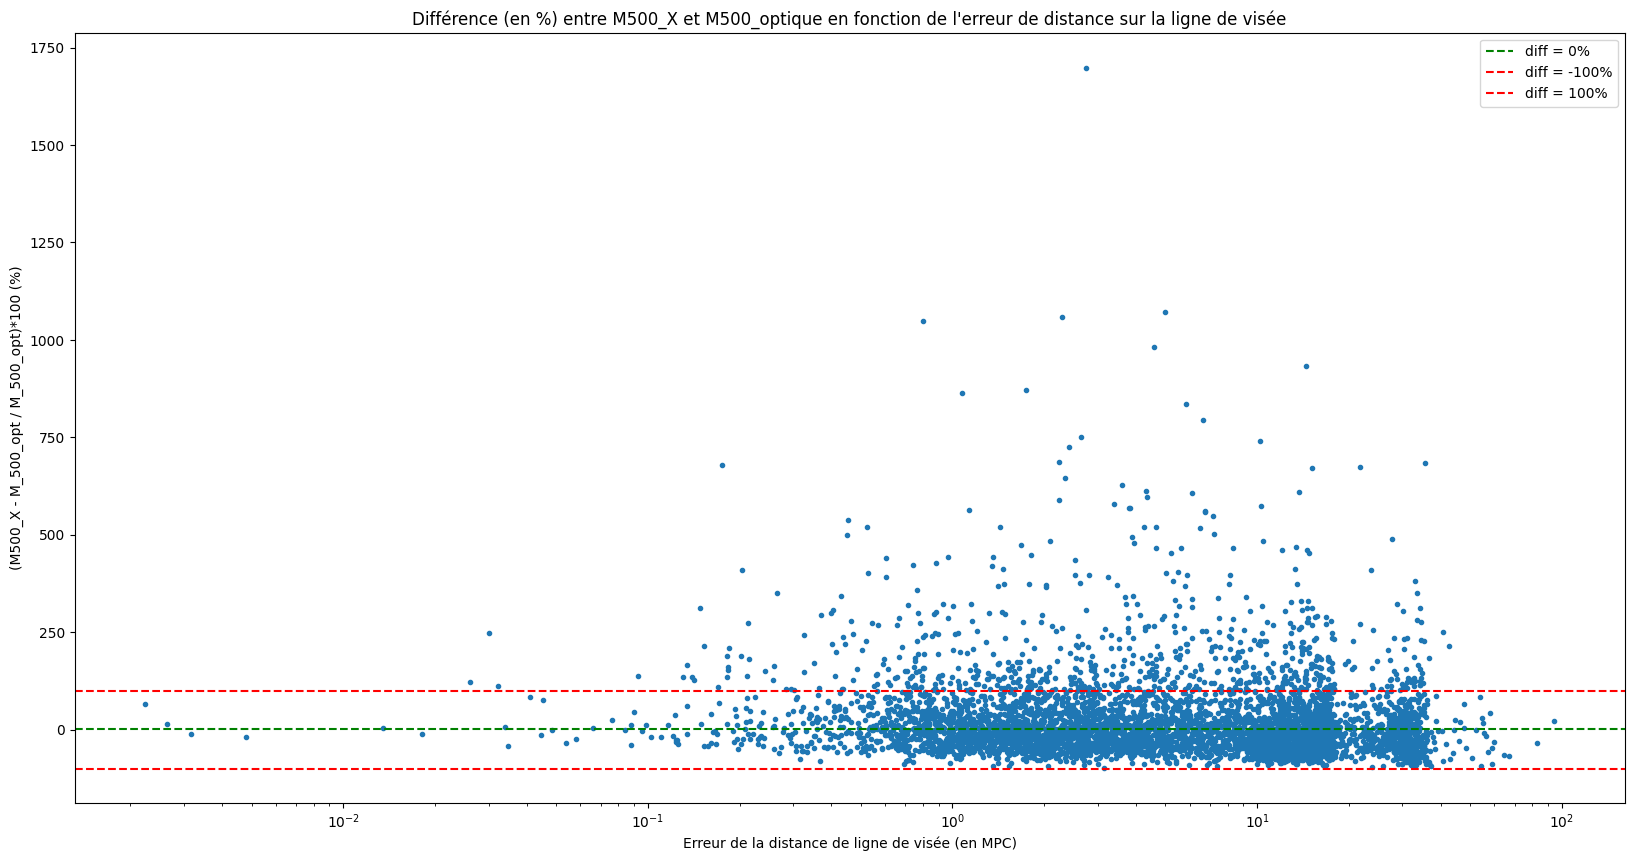

In [ ]:
#On va afficher la différence de masse entre les deux éléments de l'association en fonction de la différence de l'erreur de la distance de ligne de visée
plt.figure(figsize=(20, 10))
plt.plot(dDelta_r_list, diff_M500_1_2, 'o', markersize=3)
plt.axhline(y=1, color='green', linestyle='--', label=f'diff = 0%')
plt.axhline(y=-100, color='red', linestyle='--', label=f'diff = -100%')
plt.axhline(y=100, color='red', linestyle='--', label=f'diff = 100%')
plt.xlabel("Erreur de la distance de ligne de visée (en MPC)")
plt.ylabel('(M500_1 - M_500_2 / M_500_2)*100 (%)')
plt.title("Différence (en %) entre M500_1 et M500_2 en fonction de l'erreur de distance sur la ligne de visée")
plt.xscale('log')
plt.legend()

output_path = os.path.join(folder_plots, "diff_M500_1_2_vs_err_dist.png")
plt.savefig(output_path, dpi=300)

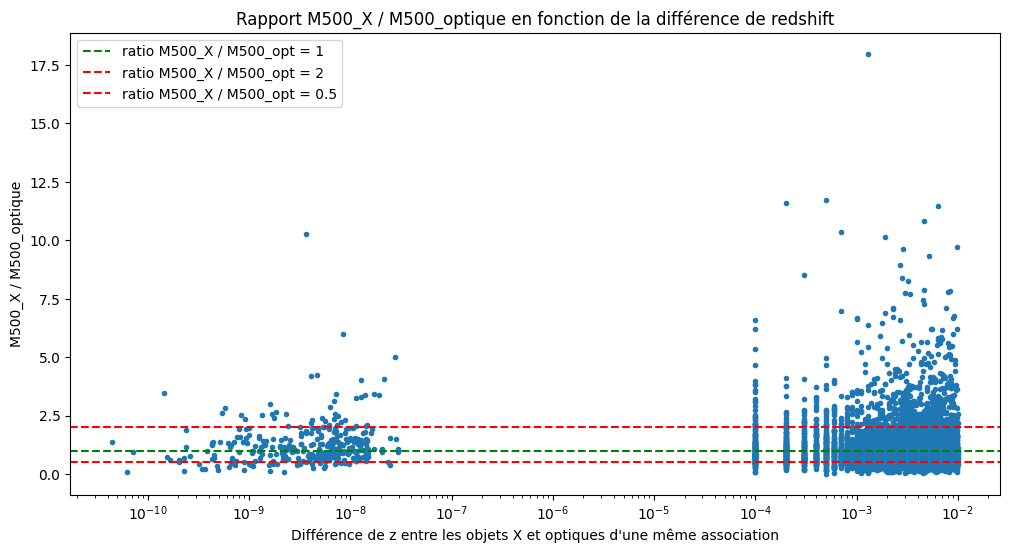

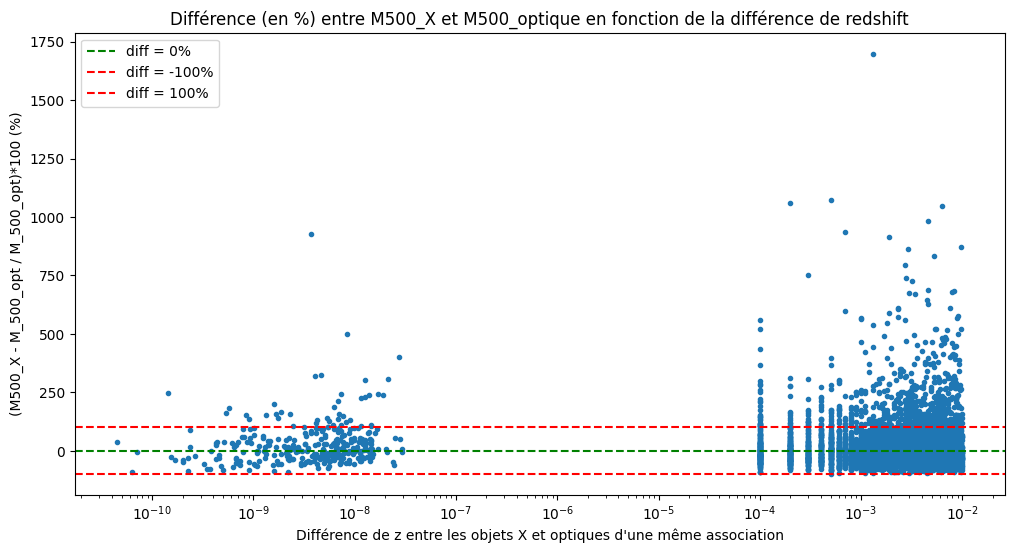

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(diff_z, ratio_M500_1_2, 'o', markersize=3)
plt.axhline(y=1, color='green', linestyle='--', label=f'ratio M500_1 / M500_2 = 1')
plt.axhline(y=2, color='red', linestyle='--', label=f'ratio M500_1 / M500_2 = 2')
plt.axhline(y=0.5, color='red', linestyle='--', label=f'ratio M500_1 / M500_2 = 0.5')
plt.xlabel("Différence de z entre les objets 1 et 2 d'une même association")
plt.ylabel('M500_1 / M500_2')
plt.title('Rapport M500_1 / M500_2 en fonction de la différence de redshift')
plt.xscale('log')
plt.legend()

output_path = os.path.join(folder_plots, "ratio_M500_1_2_vs_diff_z.png")
plt.savefig(output_path, dpi=300)

plt.figure(figsize=(12, 6))
plt.plot(diff_z, diff_M500_1_2, 'o', markersize=3)
plt.axhline(y=1, color='green', linestyle='--', label=f'diff = 0%')
plt.axhline(y=-100, color='red', linestyle='--', label=f'diff = -100%')
plt.axhline(y=100, color='red', linestyle='--', label=f'diff = 100%')
plt.xlabel("Différence de z entre les objets 1 et 2 d'une même association")
plt.ylabel('(M500_1 - M_500_2 / M_500_2)*100 (%)')
plt.title('Différence (en %) entre M500_1 et M500_2 en fonction de la différence de redshift')
plt.xscale('log')
plt.legend()

output_path = os.path.join(folder_plots, "diff_M500_1_2_vs_diff_z.png")
plt.savefig(output_path, dpi=300)


In [60]:
# Dossier où stocker les plots
folder_plots = f"../DESI_eRass/figures/{name_indexes_crossed}/"
os.makedirs(folder_plots, exist_ok=True)

'output_path = os.path.join(folder_plots, "hist_nb_assos_par_objet_X.png")\nplt.savefig(output_path, dpi=300)'

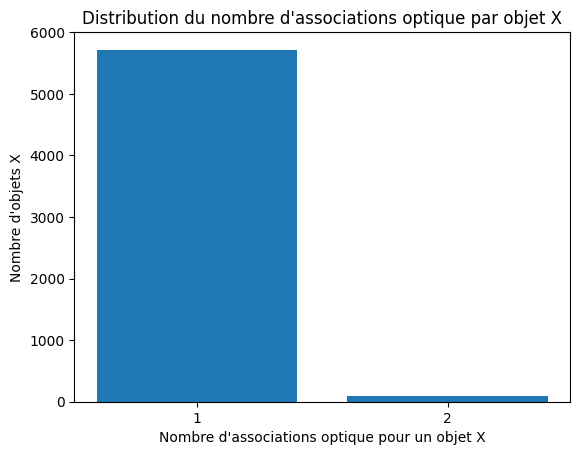

In [ ]:
# Histogramme du nombre d'associations 2 pour un objet 1


# Compte le nombre d'occurrences de chaque index (nombre d'associations pour chaque objet 1)
nb_assos_counter = Counter(indexes_1_crossed_3D) # dictionnaire avec les index 1 comme clés et le nombre d'associations 2 comme valeurs
nb_assos_list = list(nb_assos_counter.values())


plt.figure()
bins = range(int(min(nb_assos_list)), int(max(nb_assos_list)) + 2)  # +2 pour inclure la dernière valeur entière
plt.hist(nb_assos_list, bins=bins, rwidth=0.8, align='left')
plt.xticks(range(int(min(nb_assos_list)), int(max(nb_assos_list)) + 1))
plt.xlabel("Nombre d'associations 2 pour un objet 1")
plt.ylabel("Nombre d'objets 1")
plt.title("Distribution du nombre d'associations 2 par objet 1")

'''output_path = os.path.join(folder_plots, "hist_nb_assos_par_objet_1.png")
plt.savefig(output_path, dpi=300)'''

In [29]:
# Calcul proportion d'associations 1 → 2 non-univoques
nb_asso_bins = list(Counter(nb_assos_list).values())
ratio_univoques = (nb_asso_bins[0] / len(indexes_1_crossed_3D)) * 100 
print(f"Proportion d'associations 1 → 2 univoques : {round(ratio_univoques, 2)} %")

NameError: name 'nb_assos_list' is not defined

In [39]:
# graphe richesse 2 - M500


plt.figure(figsize=(20, 10))
plt.plot(M500_1, richness, 'o', markersize=3,label='objets 1')
plt.plot(M_500_2, richness, 'o', color='red', markersize=3,label='objets 2')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('lam500 (richesse 2)')
plt.title('Richesse 2 en fonction de la masse des objets')
plt.xscale('log')
plt.legend()


'''output_path = os.path.join(folder_plots, "richesse_2_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

NameError: name 'M500_1' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
borne_M_min = 10 ; borne_M_max = 50 # bornes de la masse M500 en 10^13 Msun
table_1_crossed_3D_filtered = table_1_crossed_3D[(table_1_crossed_3D['M500'] >= borne_M_min) & (table_1_crossed_3D['M500'] <= borne_M_max)]
table_2_associated_3D_filtered = table_2_associated_3D[table_2_associated_3D['id_associations'].isin(table_1_crossed_3D_filtered['id_associations'].tolist())]

print(len(table_1_crossed_3D_filtered))
print(len(table_2_associated_3D_filtered))


3878
3878


In [ ]:
M500_1_filtered = table_1_crossed_3D_filtered['M500']
M500_2_filtered = table_2_associated_3D_filtered['M500']
richness_filtered = table_2_associated_3D_filtered['lam500']
richness_filtered = table_2_associated_3D_filtered['lam500']

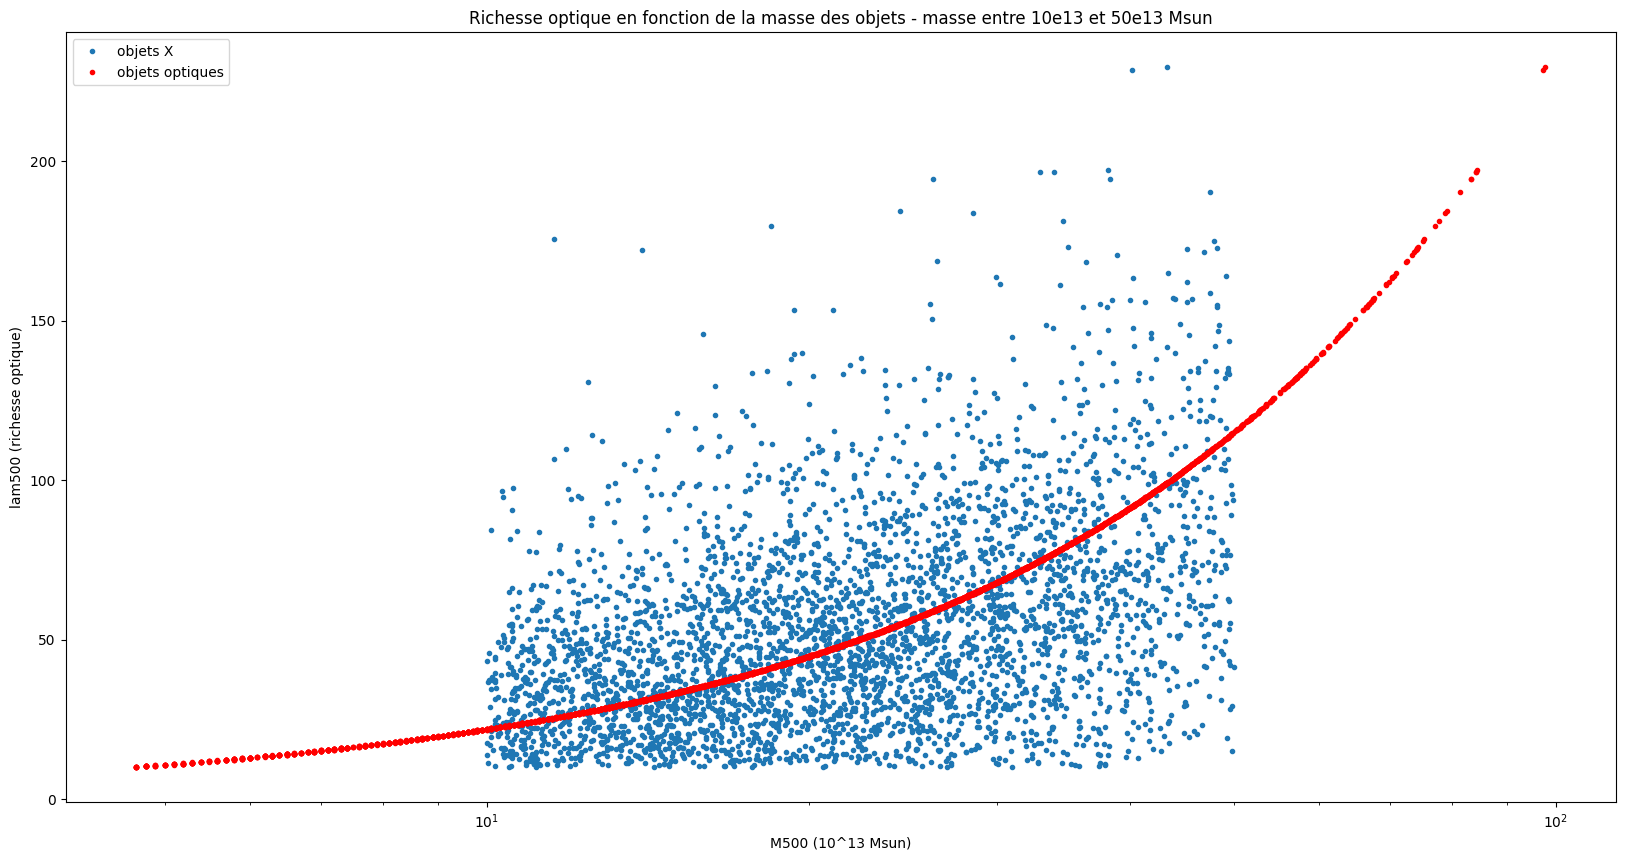

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(M500_1_filtered, richness_filtered, 'o', markersize=3,label='objets 1')
plt.plot(M500_2_filtered, richness_filtered, 'o', color='red', markersize=3,label='objets 2')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('lam500 (richesse 2)')
plt.title(f'Richesse 2 en fonction de la masse des objets - masse entre {borne_M_min}e13 et {borne_M_max}e13 Msun')
plt.xscale('log')
plt.legend()

In [37]:
# graphe T1 - M500


plt.figure(figsize=(20, 10))
plt.plot(M500_1, kT_1, 'o', markersize=3,label='objets 1')
plt.plot(M_500_2, kT_1, 'o', color='red', markersize=3,label='objets 2')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('Temperature 1 (keV)')
plt.title('Temperature 1 en fonction de la masse des objets')
plt.xscale('log')
plt.legend()

'''output_path = os.path.join(folder_plots, "richesse_2_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

NameError: name 'M500_1' is not defined

<Figure size 2000x1000 with 0 Axes>

'output_path = os.path.join(folder_plots, "count_rate_vs_M500.png")\nplt.savefig(output_path, dpi=300)'

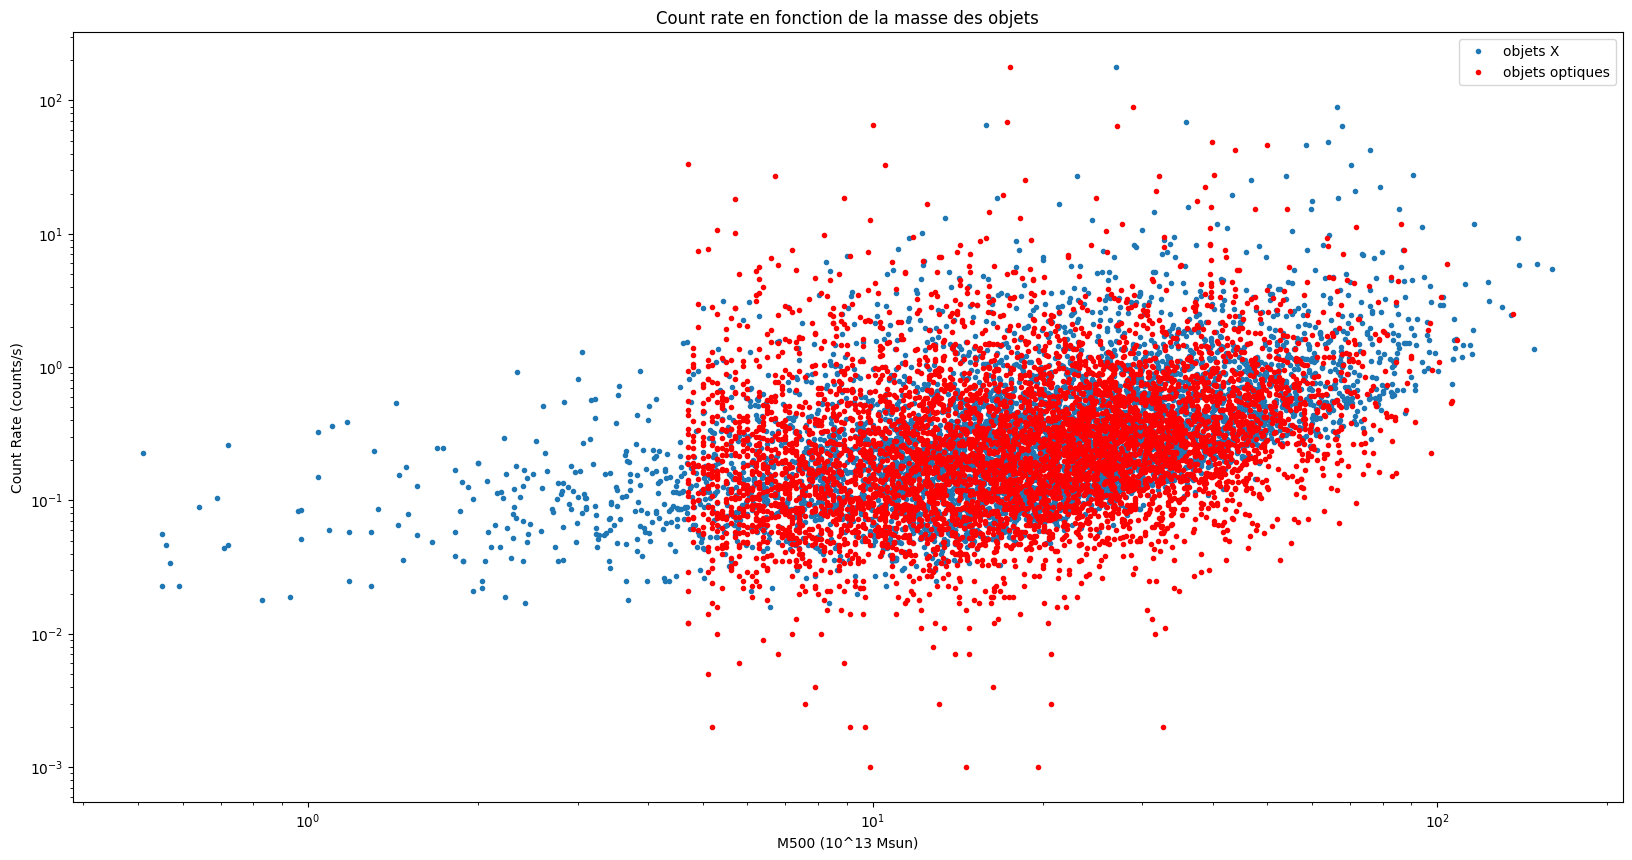

In [ ]:
# graphe CR - M500 : scaling relation eq.25 p. 15 Ghirardini et al. 2024


plt.figure(figsize=(20, 10))
plt.plot(M500_1, CR500_1, 'o', markersize=3,label='objets 1')
plt.plot(M_500_2, CR500_1, 'o', color='red', markersize=3,label='objets 2')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('Count Rate (counts/s)')
plt.title('Count rate en fonction de la masse des objets')
plt.xscale('log')
plt.yscale('log')
plt.legend()

'''output_path = os.path.join(folder_plots, "count_rate_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(M500_1, M_500_2, 'o', markersize=3)
plt.xlabel('M500 des objets 1 (10^13 Msun)')
plt.ylabel('M500 des objets 2 (10^13 Msun)')
plt.xscale('log')
plt.yscale('log')
'''output_path = os.path.join(folder_plots, "richesse_2_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

NameError: name 'M500_1' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
table_2_associated_3D

__indexes        glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
801100     801100  209.635642 -50.383836   55.04938 -18.58004  1065735          
240111     240111  200.416500 -33.241710   67.91617  -5.08618   329686    WH-   
819392     819392  201.358589 -27.736965   73.12974  -3.10617  1084027    WH-   
441160     441160  269.571465  26.480843  159.14868 -27.51825   530798    WH-   
567180     567180  302.655197  21.489060  192.51630 -41.38195   657420    WH-   
...           ...         ...        ...        ...       ...      ...    ...   
823507     823507  235.229261 -33.405857   78.75488 -32.20404  1088142    WH-   
828251     828251  249.298715 -29.519147   86.68547 -43.14817  1092886    WH-   
698902     698902  337.373813 -40.222681  316.52188 -58.74587   827614          
815954     815954  260.915480 -41.199667   69.51971 -52.92655  1080589    WH-   
73439       73439  266.170848 -69.180995   29.71560 -42.81436   143249    WH-   

                    Name    RAJ2000   DEJ2000  ...  lam500  M500  Ngal  Gamma  \
801100  J034011.9-183448   55.04938 -18.58004  ...   25.88  11.8     6    0.0   
240111  J043139.9-050510   67.91617  -5.08618  ...   12.46   5.8     9    0.0   
819392  J045231.1-030622   73.12974  -3.10617  ...   10.86   5.1     9    0.0   
441160  J103635.7-273106  159.14868 -27.51825  ...   21.93  10.0    20    0.0   
567180  J125003.9-412255  192.51630 -41.38195  ...   38.90  17.5    23    0.0   
...                  ...        ...       ...  ...     ...   ...   ...    ...   
823507  J051501.2-321215   78.75488 -32.20404  ...   11.69   5.4     7    0.0   
828251  J054644.5-430853   86.68547 -43.14817  ...   30.27  13.7     7    0.0   
698902  J210605.3-584445  316.52188 -58.74587  ...   34.87  15.7    20    0.0   
815954  J043804.7-525536   69.51971 -52.92655  ...   24.00  10.9     9    0.0   
73439   J015851.7-424852   29.71560 -42.81436  ...   10.11   4.7     6    0.0   

        e_Gamma  imag_        Cat    recno  id_asso_X  id_associations  
801100      0.0      2  CFSFDP     1065735       2552   [2552, 801100]  
240111      0.0      1              329686       3833   [3833, 240111]  
819392      0.0      2             1084027       4370   [4370, 819392]  
441160      0.0      1              530798       8094   [8094, 441160]  
567180      0.0      1              657420       9528   [9528, 567180]  
...         ...    ...        ...      ...        ...              ...  
823507      0.0      2             1088142       4854   [4854, 823507]  
828251      0.0      2             1092886       5480   [5480, 828251]  
698902      0.0      1  WH22        827614      11648  [11648, 698902]  
815954      0.0      2             1080589       3992   [3992, 815954]  
73439       0.0      1              143249        840     [840, 73439]  

[5912 rows x 26 columns]

(array([ 998., 1914., 1194.,  839.,  577.,  218.,  118.,   42.,    7.,
           5.]),
 array([0.0135 , 0.13339, 0.25328, 0.37317, 0.49306, 0.61295, 0.73284,
        0.85273, 0.97262, 1.09251, 1.2124 ]),
 <BarContainer object of 10 artists>)

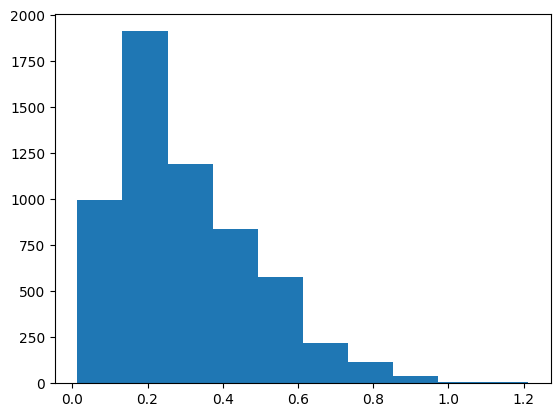

In [ ]:
plt.hist(table_2_associated_3D['zCl'])

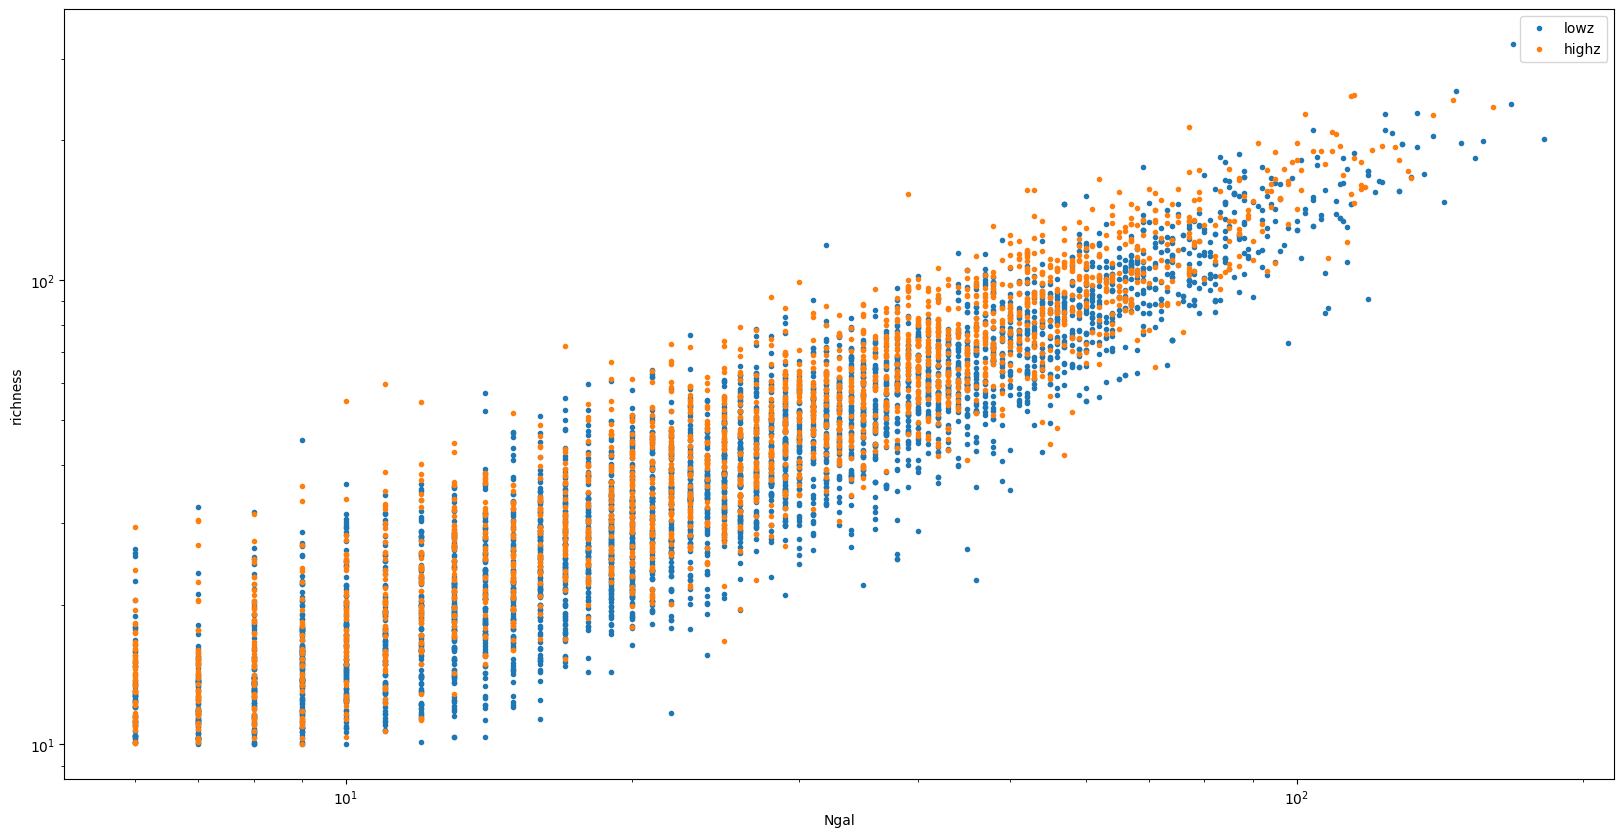

In [ ]:
table_2_associated_3D_low_z = table_2_associated_3D[table_2_associated_3D['zCl']<0.35]
table_2_associated_3D_high_z = table_2_associated_3D[table_2_associated_3D['zCl']>0.35]


N_gal_low_z = table_2_associated_3D_low_z['Ngal']
richness_low_z = table_2_associated_3D_low_z['lam500']

N_gal_high_z = table_2_associated_3D_high_z['Ngal']
richness_high_z = table_2_associated_3D_high_z['lam500']


plt.figure(figsize=(20, 10))
plt.plot(N_gal_low_z, richness_low_z, 'o', markersize=3,label='lowz')
plt.plot(N_gal_high_z, richness_high_z, 'o', markersize=3,label='highz')
plt.xlabel('Ngal')
plt.ylabel('richness')
plt.xscale('log')
plt.yscale('log')
plt.legend()

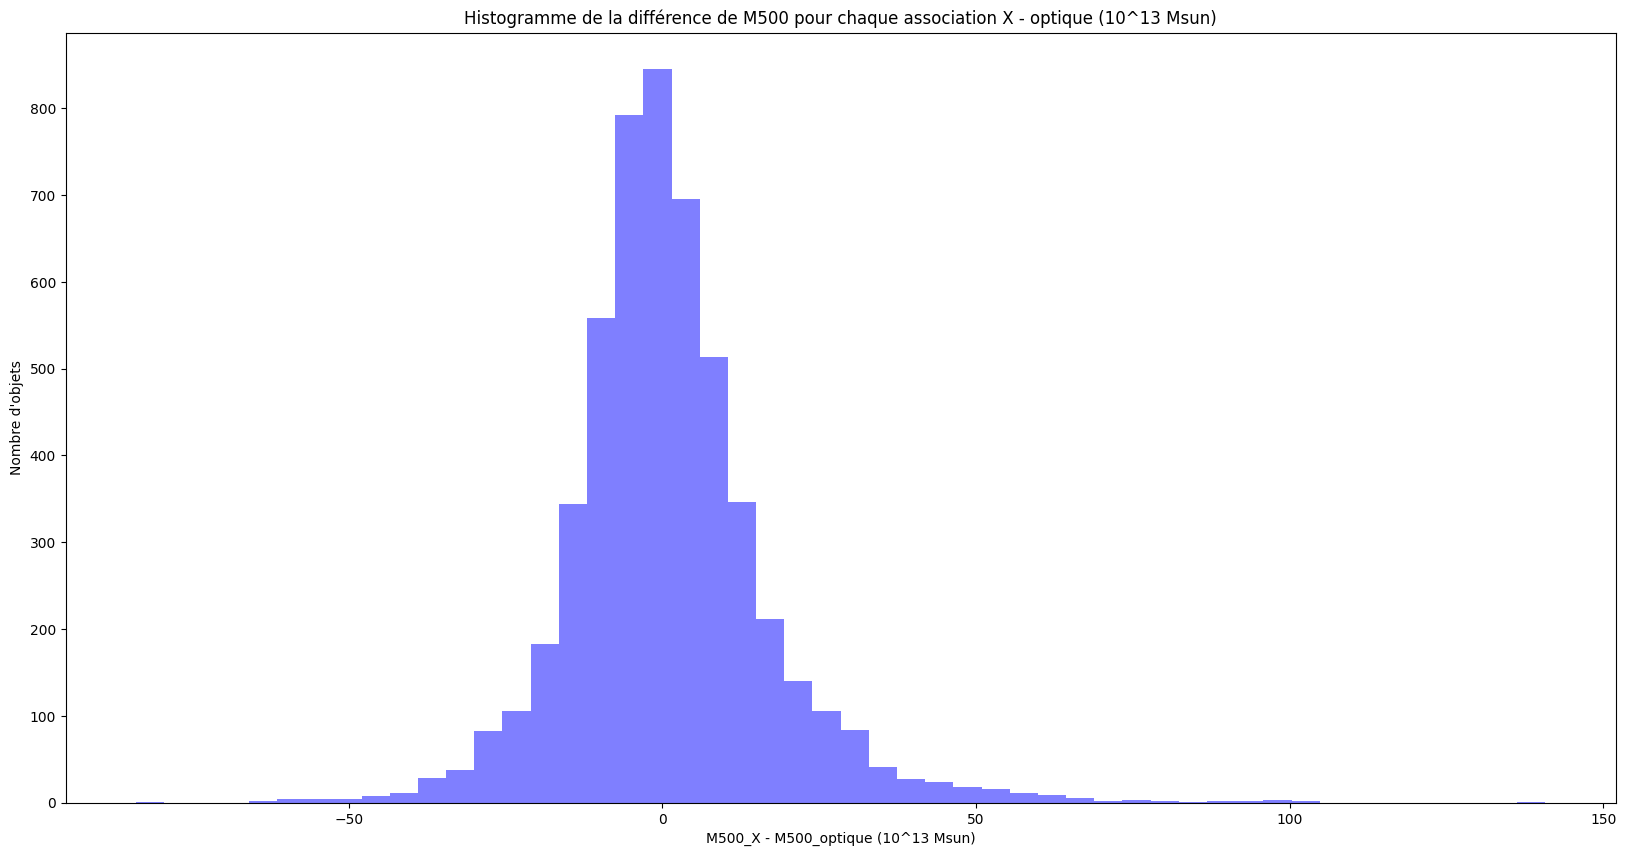

In [ ]:
# Histogramme M500_1 - M500_2
diff_mass = M500_1 - M_500_2

plt.figure(figsize=(20, 10))
plt.hist(diff_mass, bins=50, color='blue', alpha=0.5)
plt.xlabel('M500_1 - M500_2 (10^13 Msun)')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association 1 - 2 (10^13 Msun)')

output_path = os.path.join(folder_plots, "histogramme_diff_M500.png")
plt.savefig(output_path, dpi=300)

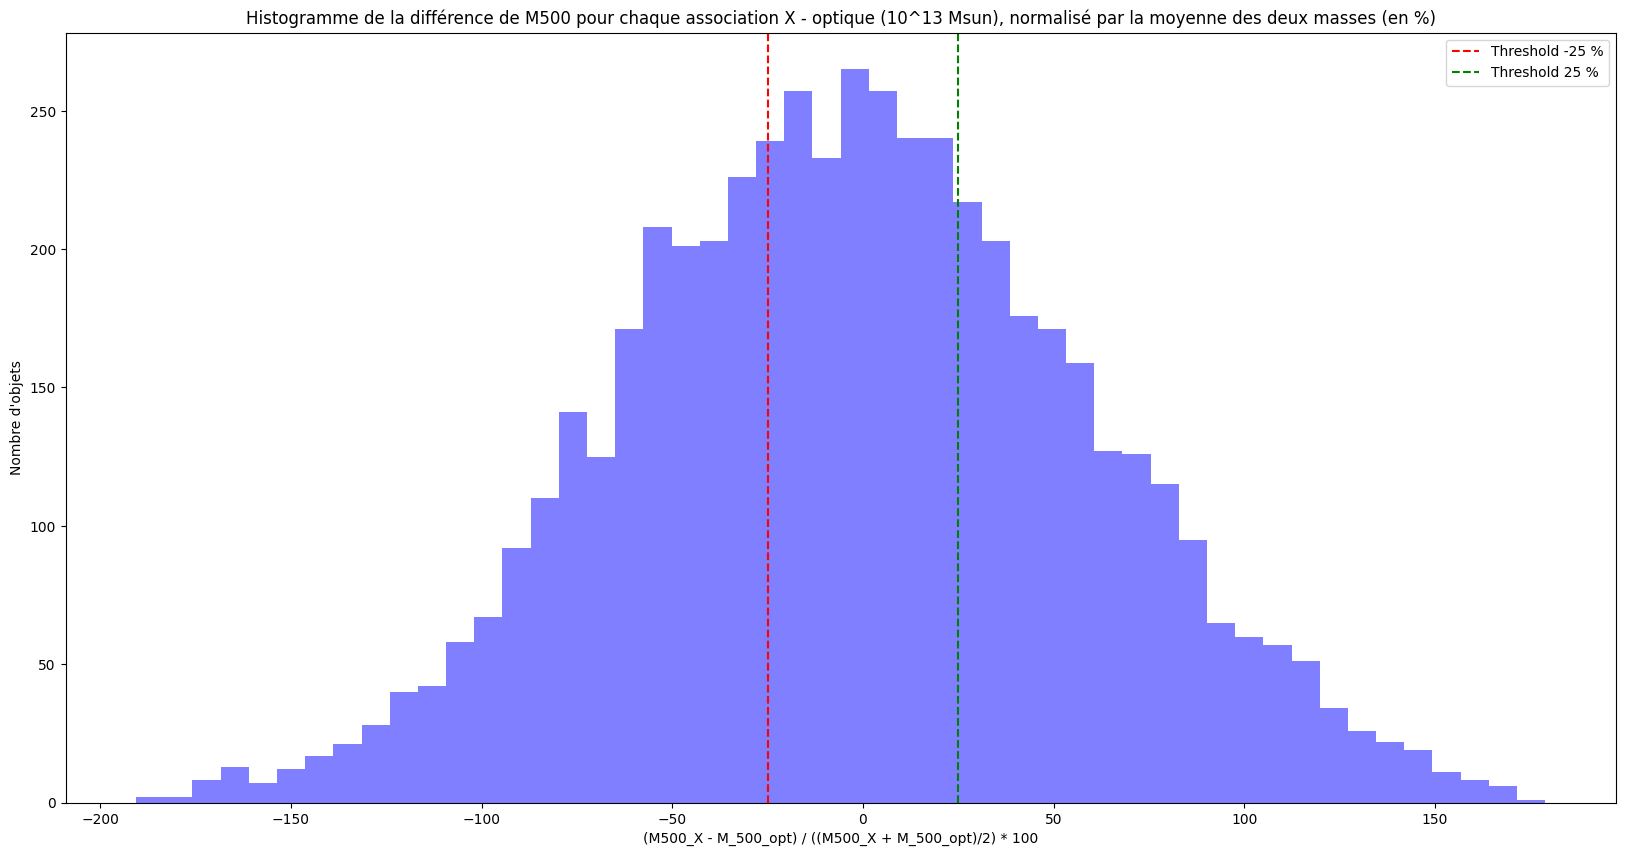

In [ ]:
diff_mass_normalisée = ((M500_1 - M_500_2) / ((M500_1 + M_500_2)/2))*100


plt.figure(figsize=(20, 10))
plt.hist(diff_mass_normalisée , bins=50, color='blue', alpha=0.5)

# Add thresholds
threshold1 = -25  # Example threshold
threshold2 = 25   # Example threshold
plt.axvline(x=threshold1, color='red', linestyle='--', label=f'Threshold {threshold1} %')
plt.axvline(x=threshold2, color='green', linestyle='--', label=f'Threshold {threshold2} %')

plt.xlabel('(M500_1 - M_500_2) / ((M500_1 + M_500_2)/2) * 100')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association 1 - 2 (10^13 Msun), normalisé par la moyenne des deux masses (en %)')

plt.legend()

output_path = os.path.join(folder_plots, "histogramme_diff_M500_normalisée.png")
plt.savefig(output_path, dpi=300)

In [ ]:
# on récupère les indices des associations dont la différence de masse normalisée est supérieure à 25% (en valeur absolue)
suspect_associations_mass = []
for i in range(len(diff_mass_normalisée)):
    if abs(diff_mass_normalisée[i]) > 25:
        suspect_associations_mass.append(i)

suspect_associations_mass_indexes = np.zeros((len(suspect_associations_mass), 2))  # Initialize a 2D array with zeros
i = 0
for x in suspect_associations_mass:
    suspect_associations_mass_indexes[i][0] = table_1_crossed_3D.iloc[x].name
    suspect_associations_mass_indexes[i][1] = table_2_associated_3D.iloc[x].name
    i += 1
suspect_associations_mass_indexes
suspect_associations_mass_indexes_1 = suspect_associations_mass_indexes[:,0].astype(int)
suspect_associations_mass_indexes_2 = suspect_associations_mass_indexes[:,1].astype(int)

output_proportion_associations_suspectes = f"Proportion d'associations suspectes en termes de différences de masse par rapport au nombre total d'associations : {round(len(suspect_associations_mass)/len(diff_mass_normalisée)*100,3)} %"
print(output_proportion_associations_suspectes)

output_path = os.path.join(folder_plots, 'proportion_associations_suspectes.txt')
with open(output_path, 'w') as f:
    f.write(output_proportion_associations_suspectes)

Proportion d'associations suspectes en termes de différences de masse par rapport au nombre total d'associations : 60.944 %


In [ ]:
suspect_associations_mass_indexes
table_1_crossed_3D_suspect = table_1_crossed_3D.loc[suspect_associations_mass_indexes_X] # On récupère les objets X des associations suspectes
table_2_associated_3D_suspect = table_2_associated_3D.loc[suspect_associations_mass_indexes_2] # On récupère les objets 2 des associations suspectes

In [ ]:
table_1_crossed_3D_suspect

__indexes        glon       glat    _RAJ2000   _DEJ2000  \
8094        8094  269.583941  26.491612  159.165881 -27.515430   
9528        9528  302.405192  21.557974  192.207279 -41.311106   
10418      10418  349.732797  65.498244  210.700883   9.338199   
219          219  306.170637 -60.907988   10.032887 -56.149109   
407          407  293.107098 -70.845207   17.476610 -45.929117   
...          ...         ...        ...         ...        ...   
10573      10573  327.688486  36.090096  214.364295 -22.612362   
5663        5663  269.268949 -29.650074   89.945854 -60.381185   
5480        5480  249.285537 -29.529085   86.669145 -43.138769   
11648      11648  337.381518 -40.221721  316.517336 -58.740395   
3992        3992  260.902174 -41.204962   69.513577 -52.915845   

                          Name     RAJ2000    DEJ2000         Exp   zBest  \
8094   1eRASS J103639.8-273055  159.165881 -27.515430  104.500000  0.0114   
9528   1eRASS J124849.7-411839  192.207279 -41.311106  177.699997  0.0110   
10418  1eRASS J140248.2+092017  210.700883   9.338199  151.199997  0.0197   
219    1eRASS J004007.8-560856   10.032887 -56.149109  143.399994  0.0282   
407    1eRASS J010954.3-455544   17.476610 -45.929117  115.199997  0.0238   
...                        ...         ...        ...         ...     ...   
10573  1eRASS J141727.4-223644  214.364295 -22.612362  167.000000  1.0334   
5663   1eRASS J055947.0-602252   89.945854 -60.381185  818.099976  1.0426   
5480   1eRASS J054640.5-430819   86.669145 -43.138769  262.100006  1.1281   
11648  1eRASS J210604.1-584425  316.517336 -58.740395   98.300003  1.1263   
3992   1eRASS J043803.2-525457   69.513577 -52.915845  542.099976  1.1774   

       ...    KT      Mgas500    YX500       M500  Fgas500  R500  id_asso_opt  \
8094   ...  3.10    74.360001   231.18  15.840000    0.047   820       441160   
9528   ...  3.19   194.779999   623.62  26.990000    0.073   979       567180   
10418  ...  1.13     0.570000     1.26   0.510000    0.014   260       623521   
219    ...  1.45    60.000000    90.41  10.870000    0.055   719        20560   
407    ...  2.35    90.449997   216.31  13.420000    0.067   773        37923   
...    ...   ...          ...      ...        ...      ...   ...          ...   
10573  ...  3.16   297.000000  1154.84  36.070000    0.077   733       633209   
5663   ...  2.25   291.130005   700.89  25.190001    0.115   648       314862   
5480   ...  2.07   228.070007   484.77  26.879999    0.078   640       828251   
11648  ...   NaN  1137.420044     0.00  73.830002    0.153   898       698902   
3992   ...   NaN   232.119995     0.00  20.240000    0.115   572       815954   

             diff_z  dist_ang  id_associations  
8094   2.100000e-03  0.017430   [8094, 441160]  
9528   4.500000e-03  0.317038   [9528, 567180]  
10418  6.258480e-11  0.003607  [10418, 623521]  
219    7.000005e-04  0.182781     [219, 20560]  
407    1.999999e-03  0.005288     [407, 37923]  
...             ...       ...              ...  
10573  8.900059e-03  0.005060  [10573, 633209]  
5663   7.199964e-03  0.003085   [5663, 314862]  
5480   3.900038e-03  0.018838   [5480, 828251]  
11648  4.800023e-03  0.007115  [11648, 698902]  
3992   4.400007e-03  0.012338   [3992, 815954]  

[3739 rows x 29 columns]

In [ ]:
table_2_associated_3D_suspect

__indexes        glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
441160     441160  269.571465  26.480843  159.14868 -27.51825   530798    WH-   
567180     567180  302.655197  21.489060  192.51630 -41.38195   657420    WH-   
623521     623521  349.740923  65.499498  210.70262   9.34136   716174          
20560       20560  305.964340 -60.851501   10.20370 -56.21416    43649          
37923       37923  293.098323 -70.842500   17.48150 -45.93113    80769          
...           ...         ...        ...        ...       ...      ...    ...   
633209     633209  327.694250  36.091289  214.36839 -22.60939   726846    WH-   
314862     314862  269.272017 -29.650960   89.94439 -60.38390   404471          
828251     828251  249.298715 -29.519147   86.68547 -43.14817  1092886    WH-   
698902     698902  337.373813 -40.222681  316.52188 -58.74587   827614          
815954     815954  260.915480 -41.199667   69.51971 -52.92655  1080589    WH-   

                    Name    RAJ2000   DEJ2000  ...  lam500  M500  Ngal  Gamma  \
441160  J103635.7-273106  159.14868 -27.51825  ...   21.93  10.0    20   0.00   
567180  J125003.9-412255  192.51630 -41.38195  ...   38.90  17.5    23   0.00   
623521  J140248.6+092029  210.70262   9.34136  ...   14.76   6.8    14   0.00   
20560   J004048.9-561251   10.20370 -56.21416  ...   15.92   7.3    11   0.00   
37923   J010955.6-455552   17.48150 -45.93113  ...   40.61  18.2    30   0.38   
...                  ...        ...       ...  ...     ...   ...   ...    ...   
633209  J141728.4-223634  214.36839 -22.60939  ...   59.69  26.5    11   0.00   
314862  J055946.7-602302   89.94439 -60.38390  ...   37.19  16.7    18   0.00   
828251  J054644.5-430853   86.68547 -43.14817  ...   30.27  13.7     7   0.00   
698902  J210605.3-584445  316.52188 -58.74587  ...   34.87  15.7    20   0.00   
815954  J043804.7-525536   69.51971 -52.92655  ...   24.00  10.9     9   0.00   

        e_Gamma  imag_        Cat    recno  id_asso_X  id_associations  
441160     0.00      1              530798       8094   [8094, 441160]  
567180     0.00      1              657420       9528   [9528, 567180]  
623521     0.00      1  CFSFDP      716174      10418  [10418, 623521]  
20560      0.00      1  CFSFDP       43649        219     [219, 20560]  
37923      0.03      1  CFSFDP       80769        407     [407, 37923]  
...         ...    ...        ...      ...        ...              ...  
633209     0.00      1              726846      10573  [10573, 633209]  
314862     0.00      1  WH22        404471       5663   [5663, 314862]  
828251     0.00      2             1092886       5480   [5480, 828251]  
698902     0.00      1  WH22        827614      11648  [11648, 698902]  
815954     0.00      2             1080589       3992   [3992, 815954]  

[3889 rows x 26 columns]